# import

In [ ]:
#pip install underthesea

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import re
import ast
from underthesea import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

# Dữ liệu

## Đọc dữ liệu

In [ ]:
# preprocessed_uit = pd.read_csv("..\\data\\preprocessed_data\\preprocessed_uit.csv")
# preprocessed_hus_fb = pd.read_csv("..\\data\\preprocessed_data\\preprocessed_hus_fb.csv")

In [ ]:
# Gop 2 file uit va hus_fb theo ti le, thanh file merged_data
merged_data = pd.read_csv("..\\data\\merged_data\\merged_data.csv")

In [ ]:
df_test = pd.read_csv("..\\data\\preprocessed_data\\preprocessed_test.csv")

## Chuyển chuỗi thành list

In [76]:
# Sử dụng hàm literal_eval để chuyển chuỗi thành list
# preprocessed_uit['Tokenized_Sentence'] = preprocessed_uit['Tokenized_Sentence'].apply(ast.literal_eval)
# preprocessed_hus_fb['Tokenized_Sentence'] = preprocessed_hus_fb['Tokenized_Sentence'].apply(ast.literal_eval)
merged_data['Tokenized_Sentence'] = merged_data['Tokenized_Sentence'].apply(ast.literal_eval)
df_test['Tokenized_Sentence'] = df_test['Tokenized_Sentence'].apply(ast.literal_eval)

In [77]:
# preprocessed_uit.shape, preprocessed_hus_fb.shape
merged_data.shape, df_test.shape

((8420, 3), (688, 3))

# MERGED

## Chia X - y

In [78]:
def split_train_valid_test(df_train_valid, df_test, train_size, valid_size, random_state=11):
    X_train, X_valid, y_train, y_valid = train_test_split(
        df_train_valid.drop('Emotion', axis=1),
        df_train_valid['Emotion'],
        test_size=valid_size/(train_size + valid_size),
        random_state=random_state,
        stratify=df_train_valid['Emotion']
    )

    X_test = df_test.drop('Emotion', axis=1)
    y_test = df_test['Emotion']

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [79]:
X_train_merged, X_valid_merged, X_test_merged, y_train_merged, y_valid_merged, y_test_merged = split_train_valid_test(
    merged_data,
    df_test,
    train_size=7,
    valid_size=3
)

In [80]:
X_train_valid_merged = pd.concat([X_train_merged, X_valid_merged], ignore_index=True)
y_train_valid_merged = pd.concat([y_train_merged, y_valid_merged], ignore_index=True)

In [84]:
X_test_merged.shape, y_test_merged.shape

((688, 2), (688,))

## TF - IDF

In [12]:
X_train_valid_merged.head(3)

Sentence  \
0  người_ta lở ăn vụn tha đi lúc đầu thấy êm re t...   
1                                    chào cam đại ca   
2  lấy chồng như 1 canh bạc . không hoa . không l...   

                                  Tokenized_Sentence  
0  [người_ta, lở, ăn, vụn tha, lúc, đầu, thấy, êm...  
1                                [chào, cam, đại ca]  
2  [lấy, chồng, 1, canh bạc, không, hoa, không, l...

### Các hàm sử dụng

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_embedding(tokens, max_features=8000, min_df=2, max_df=0.95):
    # Chuyển đổi danh sách token thành TF-IDF representation
    # max_features : Số lượng từ vựng tối đa mà  (mặc định: 8000)
    # tokens: Danh sách các token

    # Chuyển danh sách token thành chuỗi văn bản
    texts = [' '.join(token_list) for token_list in tokens]

    # Khởi tạo TfidfVectorizer
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, 2), # Sử dụng unigram và bigram
        min_df=min_df,           # Bỏ qua từ xuất hiện < min_df lần
        max_df=max_df         # Bỏ qua từ xuất hiện > max_df documents
    )

    # fit_transform
    # ma trận TF-IDF (n_samples x n_features)
    tfidf_matrix = vectorizer.fit_transform(texts)

    print("TF-IDF hoàn thành!")
    print(f"Shape: {tfidf_matrix.shape} (số câu x số từ vựng)")
    print("Số từ vựng:", len(vectorizer.get_feature_names_out()))
    print("TF-IDF - Non-zero values:", tfidf_matrix.nnz)

    return tfidf_matrix, vectorizer

In [14]:
def tfidf_transform(tokens, tfidf_vectorizer):
    texts = [' '.join(token_list) for token_list in tokens]
    return tfidf_vectorizer.transform(texts)

In [15]:
def convert_to_array(tfidf_matrix):
    return tfidf_matrix.toarray()

### Sử dụng các hàm

In [85]:
# fit_transform
train_valid_tfidf_matrix_merged, train_vectorizer_merged = tfidf_embedding(X_train_valid_merged['Tokenized_Sentence'], max_features=8000, min_df=2, max_df=0.95)

# transform
test_tfidf_matrix_merged = tfidf_transform(X_test_merged['Tokenized_Sentence'], train_vectorizer_merged)

# Chuyển sang mảng numpy
X_train_valid_arr_merged = convert_to_array(train_valid_tfidf_matrix_merged)
X_test_arr_merged = convert_to_array(test_tfidf_matrix_merged)

TF-IDF hoàn thành!
Shape: (8420, 8000) (số câu x số từ vựng)
Số từ vựng: 8000
TF-IDF - Non-zero values: 111360


## Giảm chiều

### PCA

In [17]:
from sklearn.decomposition import PCA

#### Giảm chiều PCA

In [18]:
# Chọn số chiều để giữ 90%
pca_merged = PCA(n_components=0.9)
pca_merged.fit_transform(X_train_valid_arr_merged)
print(f"Số chiều được PCA chọn để giữ 90% phương sai: {pca_merged.n_components_}")

Số chiều được PCA chọn để giữ 90% phương sai: 2978


In [19]:
X_test_pca_merged = pca_merged.transform(X_test_arr_merged)
X_test_pca_merged.shape

(8420, 2978)

In [48]:
# Tỉ lệ phương sai giải thích của từng thành phần
print("Tỉ lệ phương sai giải thích cùa 6 thành phần đầu tiên:", pca_merged.explained_variance_ratio_[:6])

# Tổng phương sai giữ lại
print("\nTổng phương sai giải thích (phương sai tích lũy):", pca_merged.explained_variance_ratio_.sum())

Tỉ lệ phương sai giải thích cùa 6 thành phần đầu tiên: [0.0046963  0.00426547 0.0039641  0.00364174 0.00361492 0.00341766]

Tổng phương sai giải thích (phương sai tích lũy): 0.9000425618566802


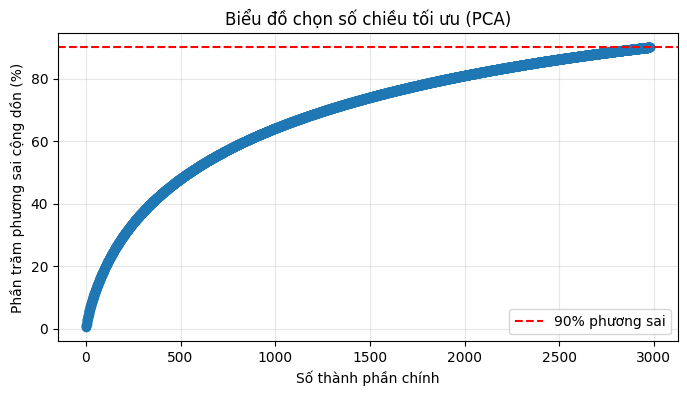

In [21]:
explained_variance = pca_merged.explained_variance_ratio_ * 100
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8,4))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.axhline(y=90, color='r', linestyle='--', label='90% phương sai')
plt.xlabel('Số thành phần chính')
plt.ylabel('Phần trăm phương sai cộng dồn (%)')
plt.title('Biểu đồ chọn số chiều tối ưu (PCA)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#### Trực quan theo từng cặp 2 chiều

In [22]:
X_train_valid_pca_merged = pca_merged.transform(X_train_valid_arr_merged)

In [24]:
X_train_valid_pca_merged_df = pd.DataFrame(
    X_train_valid_pca_merged,
    columns=[f'PC{i+1}' for i in range(X_train_valid_pca_merged.shape[1])]
)

# Thêm cột Emotion (nhãn)
X_train_valid_pca_merged_df['Emotion'] = y_train_valid_merged.values

In [25]:
X_train_valid_pca_merged_df.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.018520 -0.011215  0.011897 -0.025490 -0.032018 -0.002595  0.010237   
1 -0.001085 -0.024468 -0.008541 -0.032208 -0.017600 -0.001374 -0.004746   
2 -0.115716  0.021385 -0.052203  0.162878  0.007764 -0.032510  0.102953   
3 -0.035845  0.032638 -0.006777  0.011873  0.005935 -0.013065  0.005398   
4 -0.028363 -0.060908 -0.031571 -0.000352 -0.118411 -0.005876 -0.101139   

        PC8       PC9      PC10  ...    PC2970    PC2971    PC2972    PC2973  \
0  0.018113  0.003742 -0.006536  ... -0.013114  0.006614  0.007215 -0.001523   
1  0.004212 -0.011665  0.004461  ... -0.002373  0.006296 -0.002818  0.001469   
2 -0.026813  0.006206  0.018691  ...  0.006540  0.005338  0.012770  0.009379   
3  0.023087 -0.023374 -0.037158  ... -0.005146 -0.010420  0.004623 -0.007320   
4 -0.107835  0.030164 -0.120934  ...  0.003760 -0.004255  0.001705  0.005993   

     PC2974    PC2975    PC2976    PC2977    PC2978  Emotion  
0  0.011892 -0.016261  0.001331  0.005164 -0.000475    Other  
1 -0.002626  0.005128  0.007828 -0.002130  0.004403    Other  
2 -0.002900 -0.005314  0.002320  0.008931  0.000236  Sadness  
3  0.003266  0.010027 -0.000384  0.004873 -0.003320  Disgust  
4  0.005422  0.002335  0.015379  0.006149  0.003825  Disgust  

[5 rows x 2979 columns]

In [49]:
def plot_pca_pairs(df_pca, pairs=[(0,1), (0,2), (1,2), (2,3), (3,4), (4,5)]):
    # Thiết lập style nền
    sns.set_style("whitegrid")

    # Lấy danh sách nhãn để cố định số lượng màu (nếu cần dùng palette cụ thể)
    unique_emotions = df_pca['Emotion'].unique()
    n_colors = len(unique_emotions)

    for i, j in pairs:
        # Tạo khung hình kích thước chuẩn (8x6 như code tham khảo)
        fig, ax = plt.subplots(figsize=(8, 6))

        # Vẽ Scatterplot bằng Seaborn (Nhanh và tối ưu hơn vòng lặp thủ công)
        sns.scatterplot(
            data=df_pca,
            x=f'PC{i+1}', y=f'PC{j+1}',
            hue='Emotion',
            marker='o',
            palette='Spectral',
            alpha=0.75,             # Độ trong suốt
            s=60,                  # Kích thước điểm ảnh (to hơn chút cho rõ)
            edgecolor='white',     # Viền trắng quanh điểm để tách biệt các điểm chồng nhau
            linewidth=0.5,
            ax=ax
        )

        # 1. Vẽ đường trục toạ độ (0,0) màu xám nhạt
        ax.axhline(y=0, color="grey", linestyle="--", linewidth=1)
        ax.axvline(x=0, color="grey", linestyle="--", linewidth=1)

        # 2. Tinh chỉnh lưới (Grid)
        ax.grid(True, linestyle='--', alpha=0.5)

        # 3. Tiêu đề và Nhãn trục
        ax.set_title(f'PCA Analysis: Component {i+1} vs {j+1}', fontsize=15, fontweight='bold')
        ax.set_xlabel(f'Principal Component {i+1}', fontsize=12)
        ax.set_ylabel(f'Principal Component {j+1}', fontsize=12)

        # 4. Tinh chỉnh Legend (Chú giải)
        # Đặt legend ra ngoài để không che mất dữ liệu
        # ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='Emotion', fontsize=10)
        # loc='best': Tự động tìm chỗ trống để chui vào
        # frameon=True: Thêm khung nền trắng mờ cho legend để không bị lẫn vào lưới
        ax.legend(loc='best', title='Emotion', fontsize=9, framealpha=0.9, frameon=True)

        plt.tight_layout()
        plt.show()

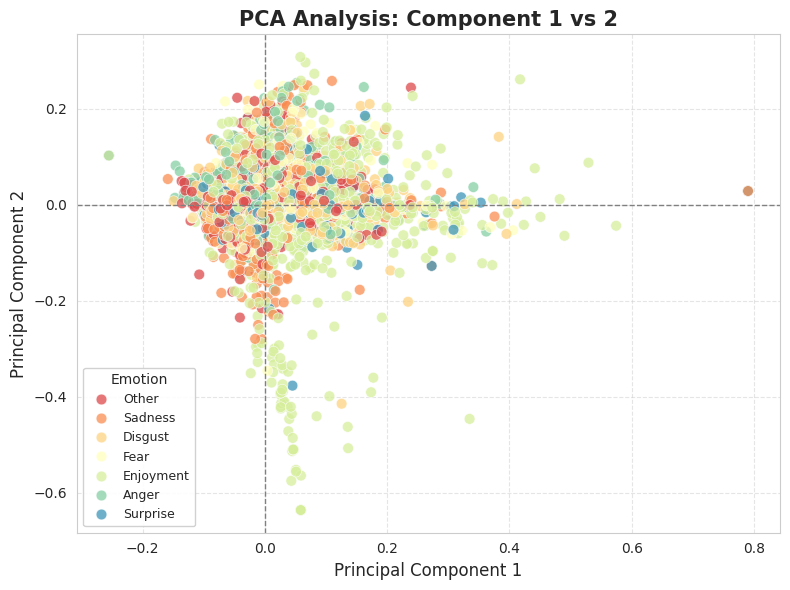

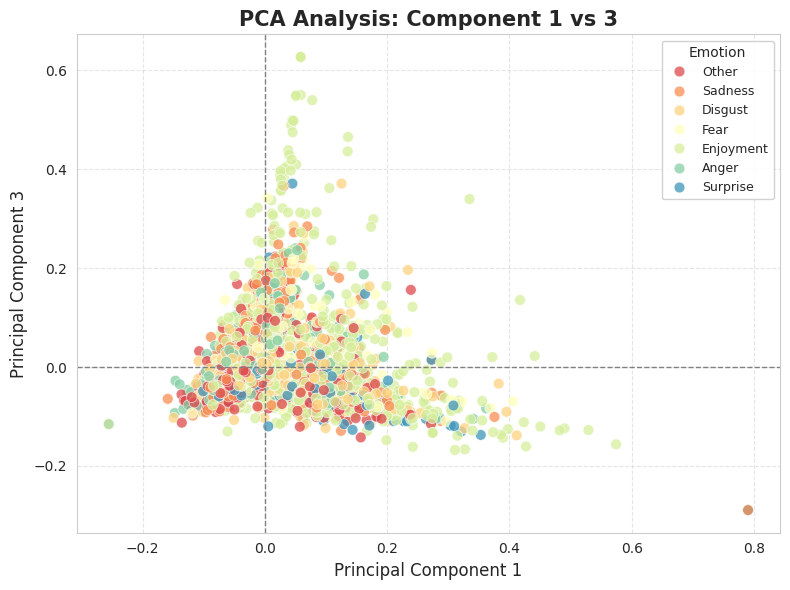

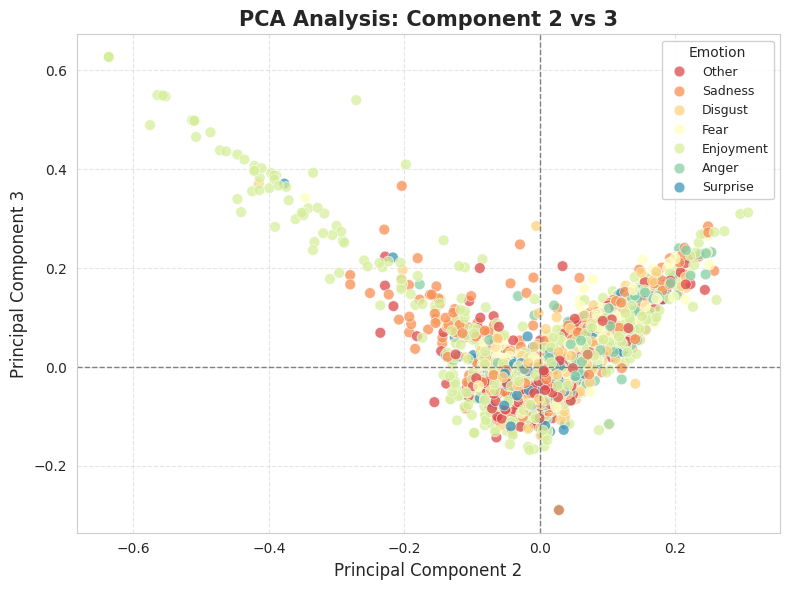

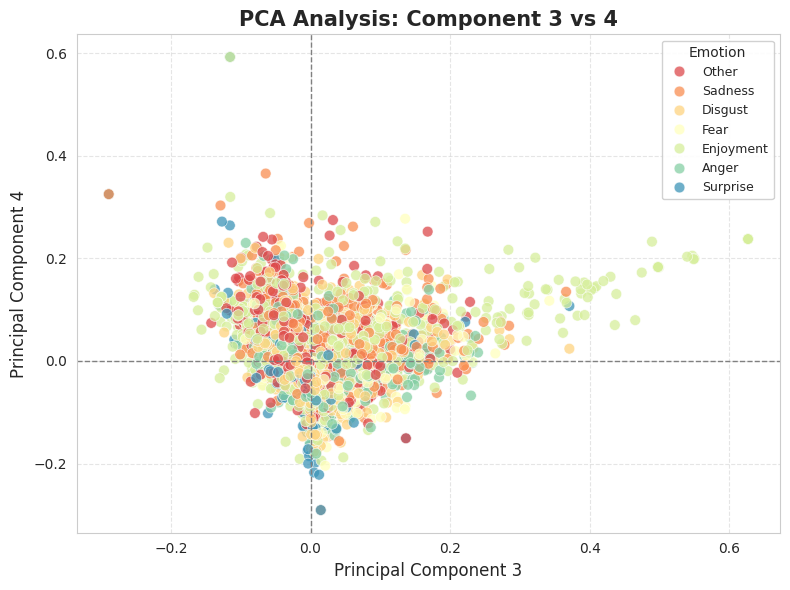

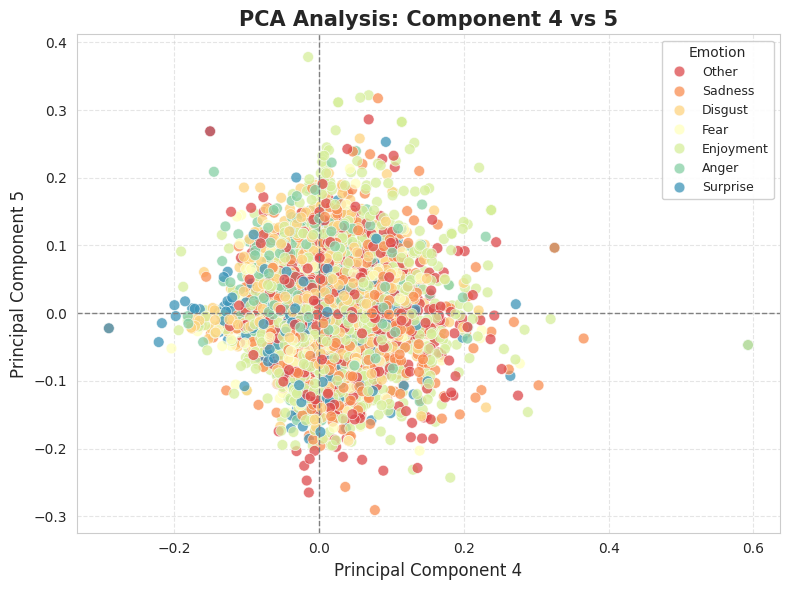

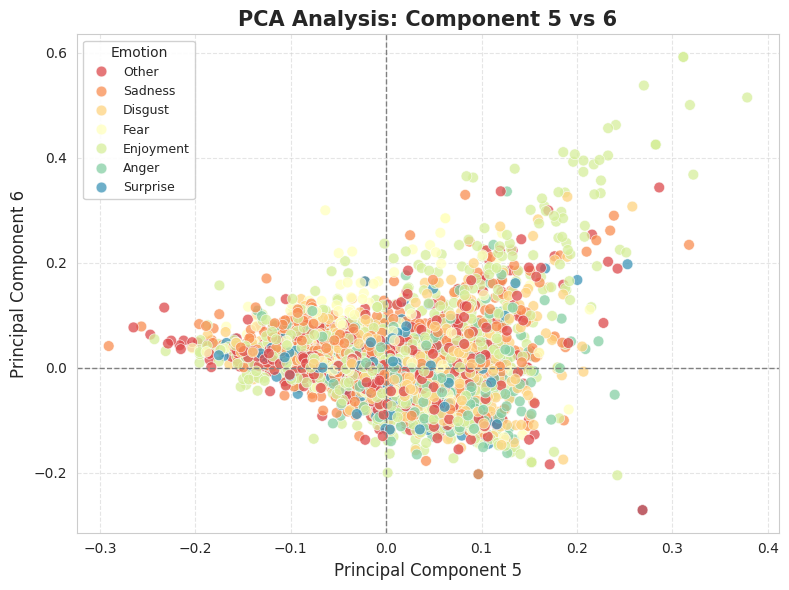

In [50]:
plot_pca_pairs(X_train_valid_pca_merged_df)

#### Vẽ cách 2 (Cách của thầy)

In [28]:
# from collections import OrderedDict

In [29]:
# # Hàm vẽ scatter plot cho từng cặp
# def plot_scatter(pc1, pc2, y, title="PCA Scatter Plot"):
#     fig, ax = plt.subplots(figsize=(8, 6))

#     # Danh sách nhãn duy nhất
#     labels_unique = list(set(y))

#     # Bảng màu (Pastel1 có sẵn 10 màu đẹp)
#     colors = sns.color_palette("muted", n_colors=len(labels_unique))

#     for i in range(len(pc1)):
#         label = y.iloc[i] if hasattr(y, "iloc") else y[i]
#         plt.scatter(pc1[i], pc2[i],
#                     s=40,
#                     c=[colors[labels_unique.index(label) % len(colors)]],
#                     label=label)

#     # Gộp nhãn trùng trong legend
#     handles, labels = plt.gca().get_legend_handles_labels()
#     by_label = OrderedDict(zip(labels, handles))
#     plt.legend(by_label.values(), by_label.keys(),
#                prop={'size': 10}, loc='best')

#     # Thêm tiêu đề, nhãn trục, và đường chia trục
#     ax.set_title(title, fontsize=14)
#     ax.set_xlabel('Principal Component 1', fontsize=12)
#     ax.set_ylabel('Principal Component 2', fontsize=12)
#     ax.axhline(y=0, color="grey", linestyle="--", linewidth=0.7)
#     ax.axvline(x=0, color="grey", linestyle="--", linewidth=0.7)
#     plt.grid(True, linestyle='--', alpha=0.5)
#     plt.show()

In [30]:
# pairs = [(0,1), (0,2), (1,2), (2,3), (3,4), (4,5)]  # ví dụ 6 chiều đầu

# for i, j in pairs:
#     pc1 = X_train_pca_uit_df[f'PC{i+1}']
#     pc2 = X_train_pca_uit_df[f'PC{j+1}']
#     plot_scatter(pc1, pc2, X_train_pca_uit_df['Emotion'],
#                  title=f"PCA Scatter Plot: PC{i+1} vs PC{j+1}")

#### Mối quan hệ của 6 TPC đầu tiên với đầu ra

/tmp/ipython-input-2499805852.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=X_train_valid_pca_merged_df, x='Emotion', y=f'PC{i+1}', palette='Spectral')


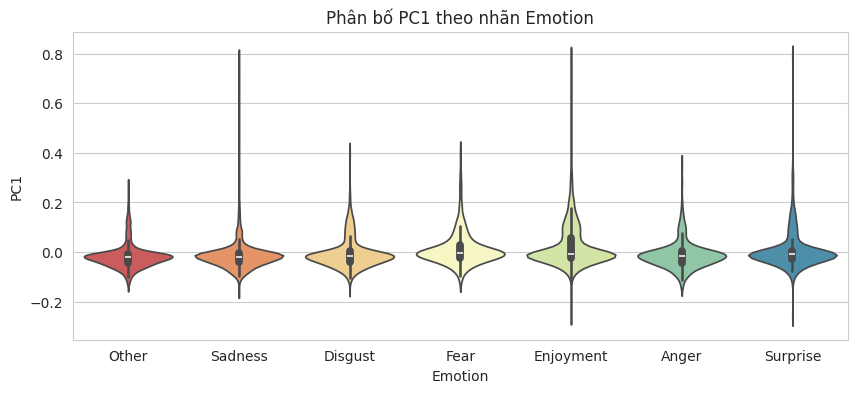

/tmp/ipython-input-2499805852.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=X_train_valid_pca_merged_df, x='Emotion', y=f'PC{i+1}', palette='Spectral')


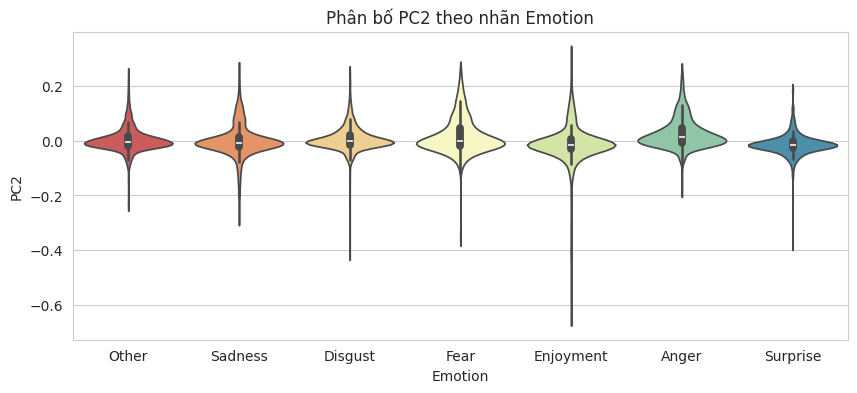

/tmp/ipython-input-2499805852.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=X_train_valid_pca_merged_df, x='Emotion', y=f'PC{i+1}', palette='Spectral')


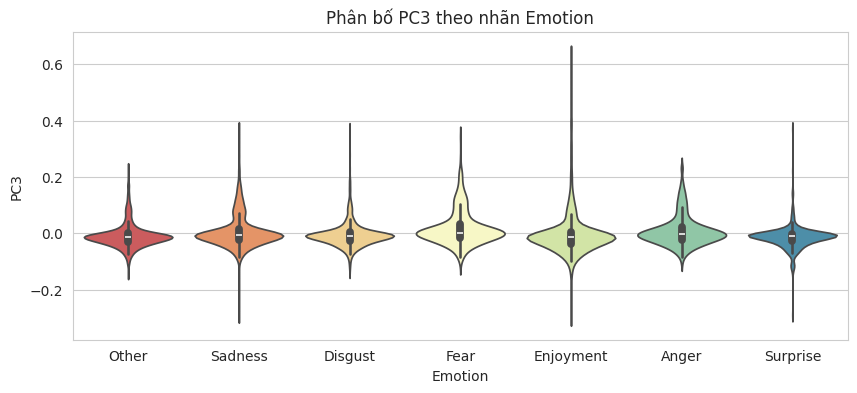

/tmp/ipython-input-2499805852.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=X_train_valid_pca_merged_df, x='Emotion', y=f'PC{i+1}', palette='Spectral')


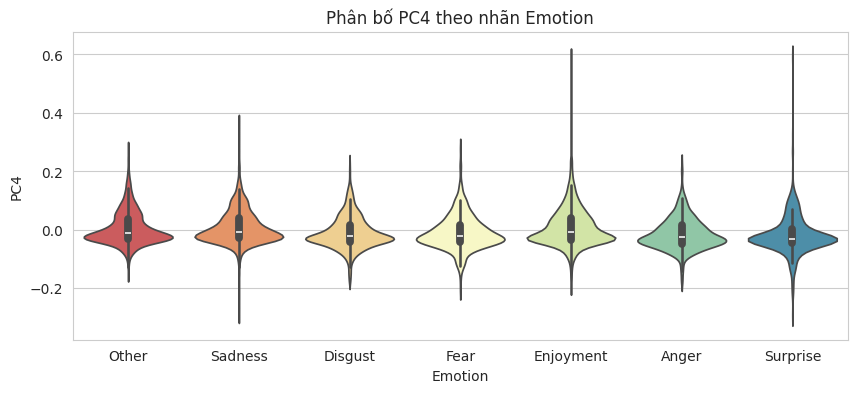

/tmp/ipython-input-2499805852.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=X_train_valid_pca_merged_df, x='Emotion', y=f'PC{i+1}', palette='Spectral')


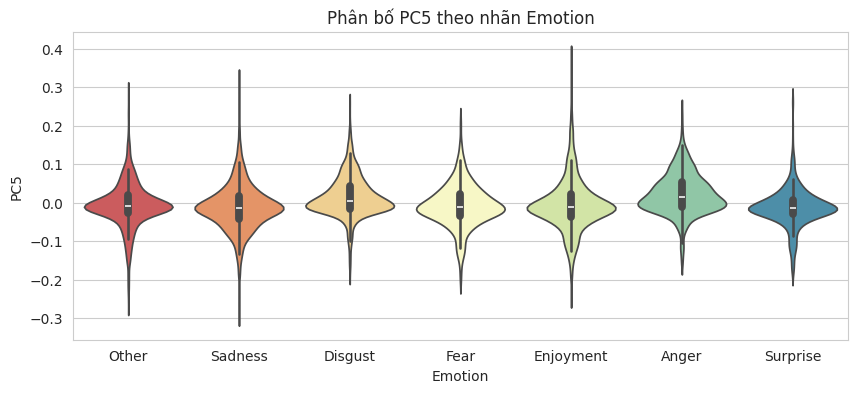

/tmp/ipython-input-2499805852.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=X_train_valid_pca_merged_df, x='Emotion', y=f'PC{i+1}', palette='Spectral')


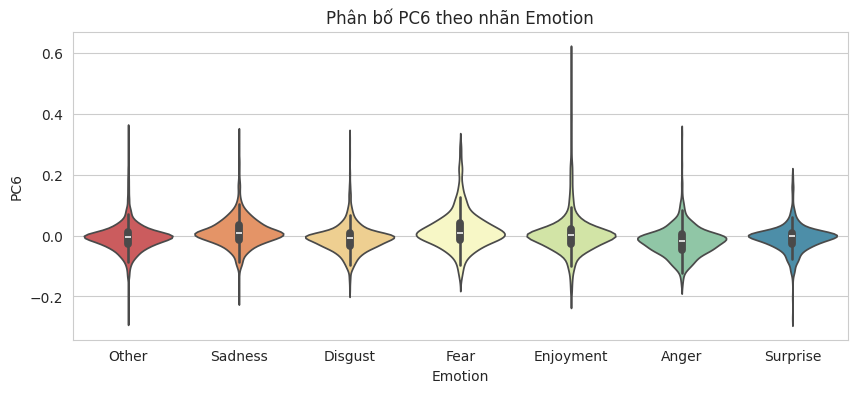

In [31]:
for i in range(6):
    plt.figure(figsize=(10, 4))
    sns.violinplot(data=X_train_valid_pca_merged_df, x='Emotion', y=f'PC{i+1}', palette='Spectral')
    plt.title(f'Phân bố {f"PC{i+1}"} theo nhãn Emotion')
    plt.xlabel('Emotion')
    plt.ylabel(f'PC{i+1}')
    plt.show()

Nhận xét: Hầu hết 6 TPC đều không phân biệt rõ cảm xúc, tức là do PCA chưa khai thác được cấu trúc cảm xúc (có thể do phương pháp embedding chưa đủ ngữ nghĩa của câu chẳng hạn)

In [32]:
# Phân tích ANOVA: chưa biết đề làm gì :<
from scipy.stats import f_oneway

groups = [X_train_valid_pca_merged_df[X_train_valid_pca_merged_df['Emotion'] == emo]['PC1'] for emo in X_train_valid_pca_merged_df['Emotion'].unique()]
f_stat, p_val = f_oneway(*groups)
print(f"F-statistic: {f_stat:.3f}, p-value: {p_val:.5f}")


F-statistic: 89.815, p-value: 0.00000


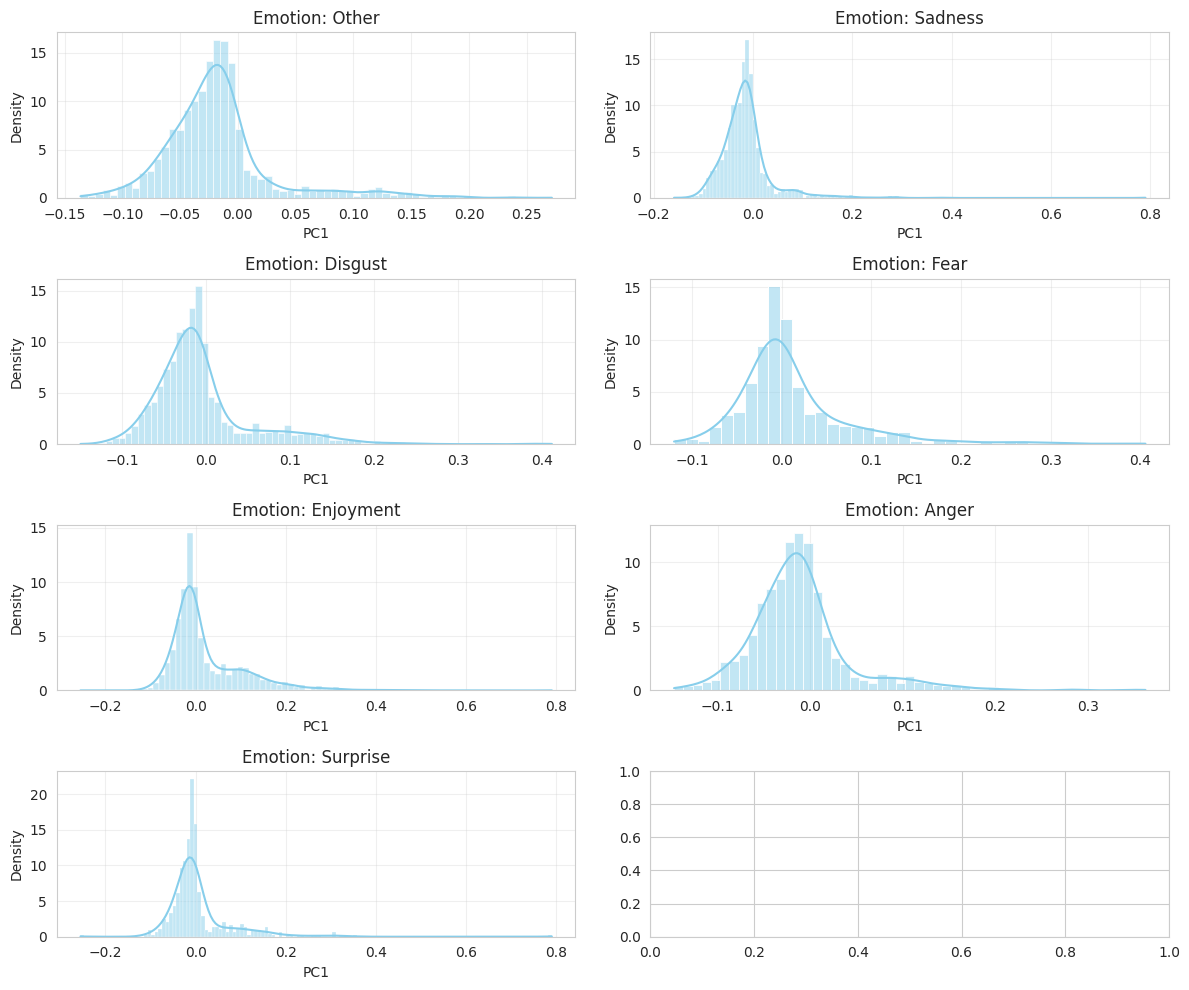

In [33]:
# Vẽ bằng histogram thì xem phân phối DL rõ hơn, nhưng box plot xem được trung vị
emotions = X_train_valid_pca_merged_df['Emotion'].unique()
n = len(emotions)
fig, axes = plt.subplots(nrows=(n//2 + n%2), ncols=2, figsize=(12, 10))

for ax, emo in zip(axes.flatten(), emotions):
    sns.histplot(data=X_train_valid_pca_merged_df[X_train_valid_pca_merged_df['Emotion']==emo],
                 x='PC1', kde=True, stat='density', color='skyblue', ax=ax)
    ax.set_title(f'Emotion: {emo}')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Density: mật độ

### LDA

- Tìm ma trận W chiếu DL vào không gian LDA
- Sau khi học được W, tính các hàm phân biệt tuyến tính (linear discriminats) để dự đoán lớp
- Thay vì mỗi TPC giữ một phần thông tin như PCA, thì LDA sẽ giữ một phần thông tin giúp phân biệt giữa các lớp
- Vì thế, LDA có thể giảm còn số chiều max là (n-1) chiều (n là số nhãn)

In [34]:
X_train_valid_arr_merged.shape

(8420, 8000)

#### LDA còn 6 chiều

In [35]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [36]:
lda_merged = LinearDiscriminantAnalysis(n_components=6)
X_train_valid_lda_merged = lda_merged.fit_transform(X_train_valid_arr_merged, y_train_valid_merged)

#### In các tham số tuyến tính cho bài toán phân loại
Hàm phân biệt:

theta_k(x) = x^T. sum^(-1)(u_k) - 1/2 * u_k^T. sum^(-1)(y_k) + log(P(C_k))

In [37]:
# In ra các tham số tuyến tính cho bài toán phân loại
print("Hệ số hàm phân biệt:")
print(lda_merged.coef_)      # Hệ số của hàm phân biệt (mỗi hàng là 1 lớp)
print()
print("Hệ số chặn:")
print(lda_merged.intercept_) # bias theta_k(x) = w_k^Tx + b_k,   w_k là coef

Hệ số hàm phân biệt:
[[   73.89600697   -43.32919998  -515.87576548 ...   131.66548811
    692.49382776 -1031.67649914]
 [ -248.49565521    21.55514999   383.59031225 ...   225.94425267
   -219.7914846   -934.14117787]
 [    4.74679064   168.86755319  -388.3963953  ...   243.06134153
  -1080.87435025   615.01385486]
 ...
 [  164.05268703  -218.20299323   101.83573464 ...  -110.24932122
    607.12760345   749.82196786]
 [  127.00338674    50.35009434  -581.41212037 ...  -545.47004123
   2300.87791027  -469.25700186]
 [   39.64137344    88.11435698  1438.27388378 ...   285.60117629
  -2338.76120547   292.39327974]]

Hệ số chặn:
[-223.28599456 -118.12219242  -55.16423427 -302.59495896  -54.49329584
 -141.15806817  -42.27794267]


In [38]:
X_train_valid_lda_merged.shape

(8420, 6)

- LDA tìm ra 6 hướng giúp phân biệt tâm của 7 label
- Các vector riêng của S_w^-1 * S_B mô tả toàn bộ thông tin phân biệt giữa các lớp, tức là TOÀN BỘ KHẢ NĂNG PHÂN BIỆT đã ở trong 6 chiều này

In [39]:
# Tỉ lệ phương sai giải thích của từng thành phần
print("Tỉ lệ phương sai giải thích cùa 6 thành phần:", lda_merged.explained_variance_ratio_)

# Tổng phương sai giữ lại
print("Tổng phương sai giải thích (phương sai tích lũy):", lda_merged.explained_variance_ratio_.sum())

Tỉ lệ phương sai giải thích cùa 6 thành phần: [0.24579521 0.21251542 0.17067039 0.15826944 0.14872962 0.06401992]
Tổng phương sai giải thích (phương sai tích lũy): 1.0


#### Trực quan hóa phương sai giải thích

In [40]:
# Lấy tỷ lệ phương sai giải thích
explained_variance_ratio_lda = lda_merged.explained_variance_ratio_ * 100  # chuyển sang %
n_components_lda = len(explained_variance_ratio_lda)

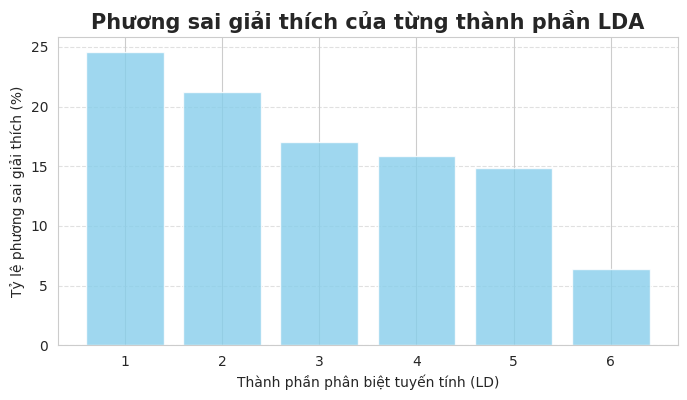

In [52]:
# Vẽ biểu đồ cột
plt.figure(figsize=(8, 4))
plt.bar(range(1, n_components_lda + 1), explained_variance_ratio_lda,alpha = 0.8, color = 'skyblue')
plt.ylabel('Tỷ lệ phương sai giải thích (%)')
plt.xlabel('Thành phần phân biệt tuyến tính (LD)')
plt.title('Phương sai giải thích của từng thành phần LDA', fontsize=15, fontweight ='bold')
plt.xticks(range(1, n_components_lda + 1))
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

#### Trực quan DL theo từng cặp TPC

In [53]:
# Chuyển thành df
X_train_valid_lda_merged_df = pd.DataFrame(
    X_train_valid_lda_merged,
    columns=[f'LD{i+1}' for i in range(X_train_valid_lda_merged.shape[1])]
)
X_train_valid_lda_merged_df['Emotion'] = y_train_valid_merged.values  # thêm nhãn cảm xúc

In [60]:
# Thiết lập style chung
sns.set(style="whitegrid")

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Liberation Sans', 'Tahoma', 'Arial']

plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.labelweight'] = 'bold'

Nhận xét: Sau khi dùng LDA, các lớp đã được phân biệt rõ hơn, đặc biệt ở TPC1 với TPC2 và TCP3

In [87]:
def plot_lda_pairs(df, pairs=[(0,1), (0,2), (1,2)], label_col='Emotion'):
    """
    Hàm vẽ biểu đồ LDA theo từng cặp thành phần (LD) với style đẹp mắt.

    Args:
        df (pd.DataFrame): DataFrame chứa dữ liệu LDA (các cột LD1, LD2...) và nhãn.
        pairs (list): Danh sách các cặp chỉ số cần vẽ. VD: [(0,1)] tương ứng LD1 vs LD2.
        label_col (str): Tên cột chứa nhãn cảm xúc.
    """
    # sns.set_style("whitegrid")

    # # Cài đặt font và kích thước chữ
    # plt.rcParams['font.family'] = 'Arial'
    # plt.rcParams['axes.titlesize'] = 15
    # plt.rcParams['axes.titleweight'] = 'bold'
    # plt.rcParams['axes.labelsize'] = 12
    # plt.rcParams['axes.labelweight'] = 'bold'

    # ==========================================
    # 2. VÒNG LẶP VẼ BIỂU ĐỒ
    # ==========================================
    for i, j in pairs:
        # Tên cột trong DataFrame (VD: LD1, LD2...)
        col_x = f'LD{i+1}'
        col_y = f'LD{j+1}'

        # Tạo khung hình
        fig, ax = plt.subplots(figsize=(8, 6))

        # Vẽ Scatterplot
        sns.scatterplot(
            data=df,
            x=col_x,
            y=col_y,
            hue=label_col,
            palette='Spectral',       # Bảng màu chuẩn đẹp
            alpha=0.75,             # Độ trong suốt
            s=30,                  # Kích thước điểm
            edgecolor=None,     # Viền trắng nổi bật
            linewidth=0.5,
            marker='o',            # Hình tròn
            ax=ax
        )

        # --- TRANG TRÍ ---

        # 1. Đường tâm (0,0) - Quan trọng cho LDA
        ax.axhline(y=0, color="grey", linestyle="--", linewidth=1)
        ax.axvline(x=0, color="grey", linestyle="--", linewidth=1)

        # 2. Tiêu đề và Nhãn trục
        ax.set_title(f'Biểu đồ LDA: {col_x} vs {col_y}')
        ax.set_xlabel(f'Thành phần phân biệt tuyến tính {i+1} ({col_x})')
        ax.set_ylabel(f'Thành phần phân biệt tuyến tính {j+1} ({col_y})')

        # 3. Legend (Nằm bên trong, tự động tìm chỗ trống)
        ax.legend(title=label_col, loc='best', frameon=True, framealpha=0.9)

        # 4. Lưới
        ax.grid(True, linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.show()

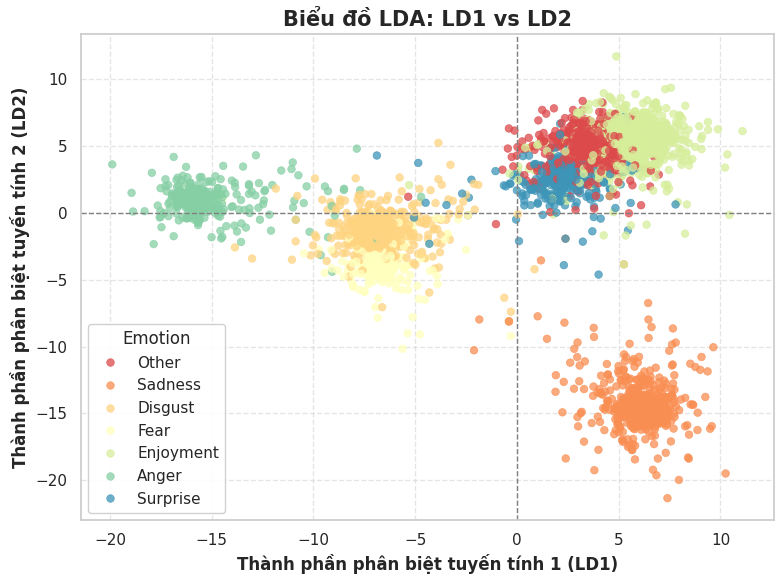

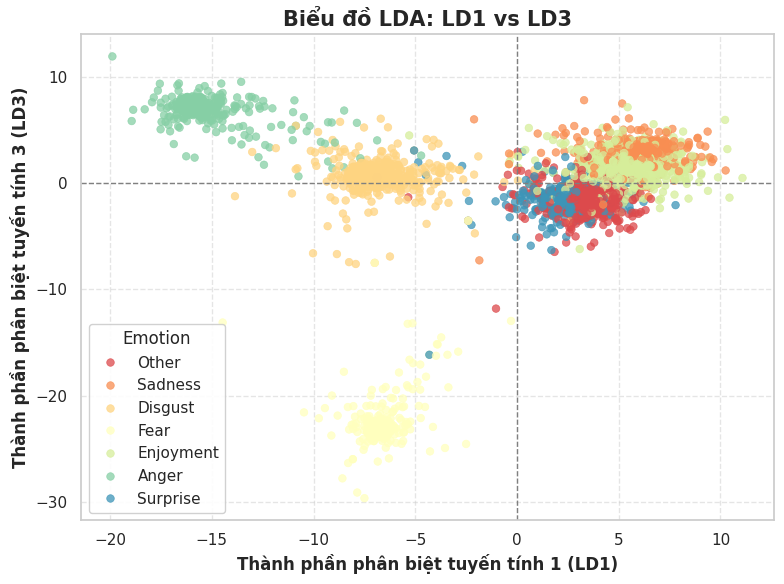

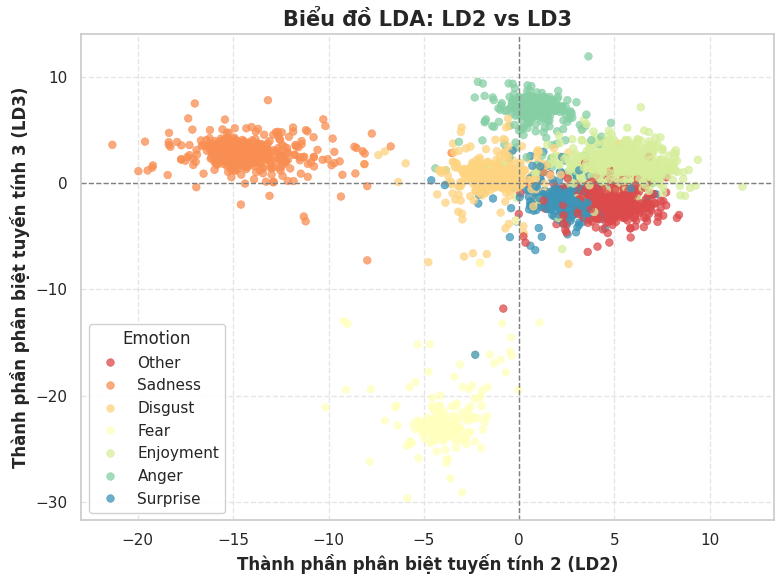

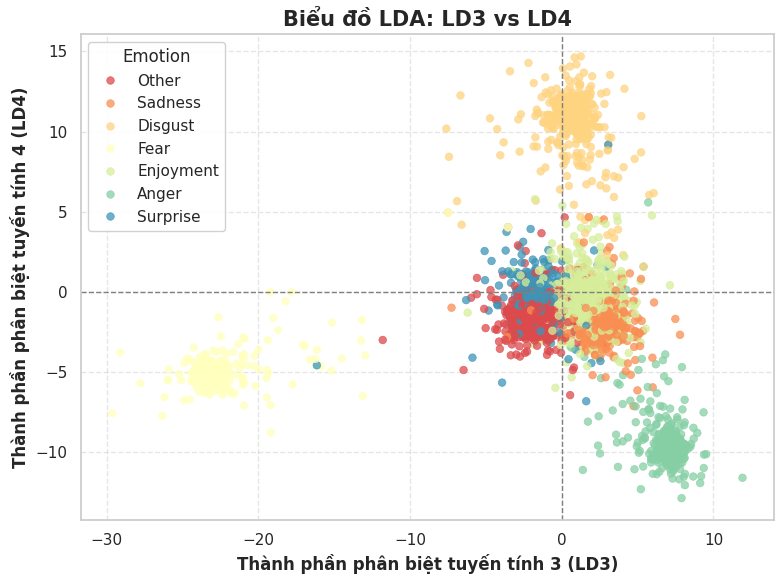

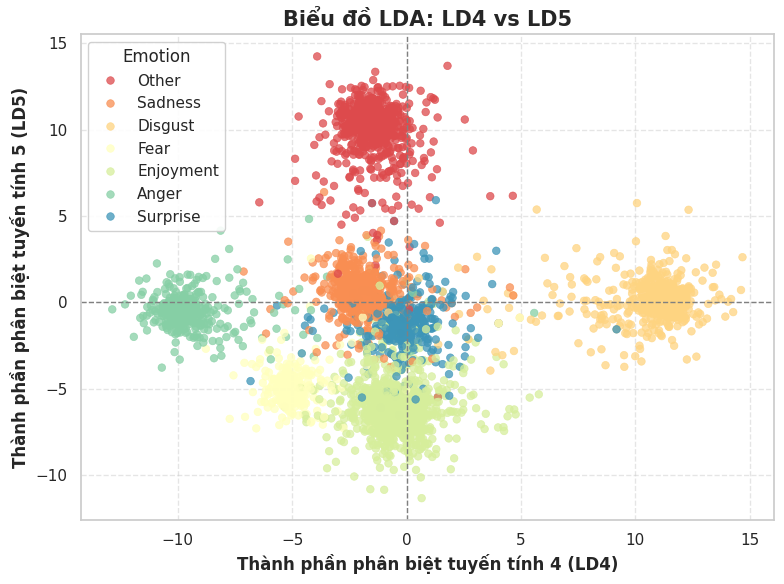

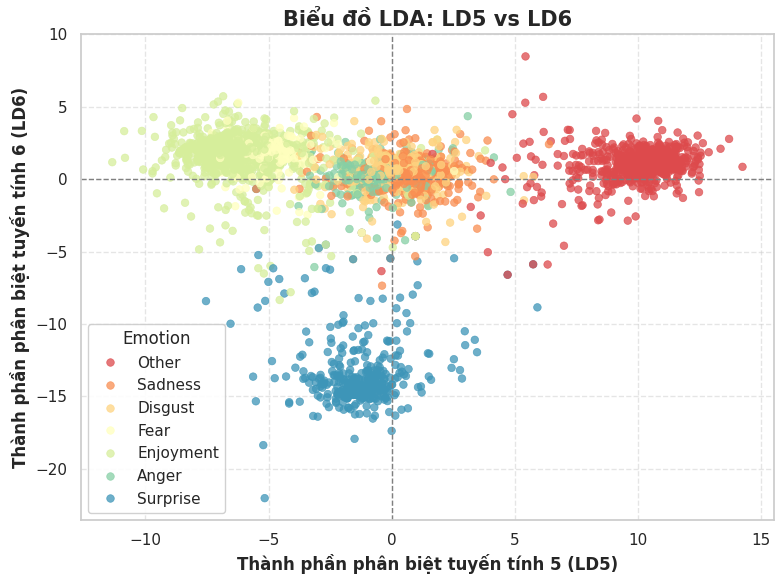

In [88]:
pairs_to_plot = [(0,1), (0,2), (1,2), (2,3), (3,4), (4,5)]

# Và gọi hàm (truyền đúng tên biến DataFrame của bạn vào)
plot_lda_pairs(X_train_valid_lda_merged_df, pairs=pairs_to_plot, label_col='Emotion')

In [89]:
def compare_lda_train_test(train_df, test_df, pair=(0,1)):
    """
    Vẽ so sánh phân bố LDA giữa tập Train và tập Test với màu sắc cố định chuẩn.
    """
    i, j = pair
    col_x, col_y = f'LD{i+1}', f'LD{j+1}'

    # --- CẤU HÌNH MÀU SẮC QUAN TRỌNG ---
    # 1. Thứ tự nhãn y hệt như trong hình Legend mẫu của bạn
    # Điều này đảm bảo: Other luôn đỏ, Surprise luôn xanh, Sadness luôn cam...
    fixed_hue_order = ['Other', 'Sadness', 'Disgust', 'Fear', 'Enjoyment', 'Anger', 'Surprise']

    # Setup khung hình
    fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharex=True, sharey=True)

    # --- VẼ TẬP TRAIN ---
    sns.scatterplot(
        data=train_df, x=col_x, y=col_y, hue='Emotion',
        palette='Spectral',
        hue_order=fixed_hue_order,  # <--- THÊM DÒNG NÀY (Cố định thứ tự màu)
        alpha=0.6, s=40, edgecolor='white', linewidth=0.3,
        ax=axes[0], legend=False
    )
    axes[0].set_title(f'TẬP TRAIN\n({len(train_df)} mẫu)', fontweight='bold', color='navy')
    axes[0].grid(True, linestyle='--', alpha=0.5)
    axes[0].axhline(0, color='grey', ls='--', lw=1)
    axes[0].axvline(0, color='grey', ls='--', lw=1)

    # --- VẼ TẬP TEST ---
    sns.scatterplot(
        data=test_df, x=col_x, y=col_y, hue='Emotion',
        palette='Spectral',
        hue_order=fixed_hue_order,  # <--- THÊM DÒNG NÀY CHO CẢ TEST (Để đồng bộ)
        alpha=0.8, s=60, edgecolor='white', linewidth=0.5,
        ax=axes[1]
    )
    axes[1].set_title(f'TẬP TEST (Thực tế)\n({len(test_df)} mẫu)', fontweight='bold', color='darkred')
    axes[1].grid(True, linestyle='--', alpha=0.5)
    axes[1].axhline(0, color='grey', ls='--', lw=1)
    axes[1].axvline(0, color='grey', ls='--', lw=1)

    # Chỉnh lại legend
    axes[1].legend(title='Emotion', loc='upper right', bbox_to_anchor=(1.3, 1))

    plt.suptitle(f'So sánh không gian LDA: {col_x} vs {col_y}', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

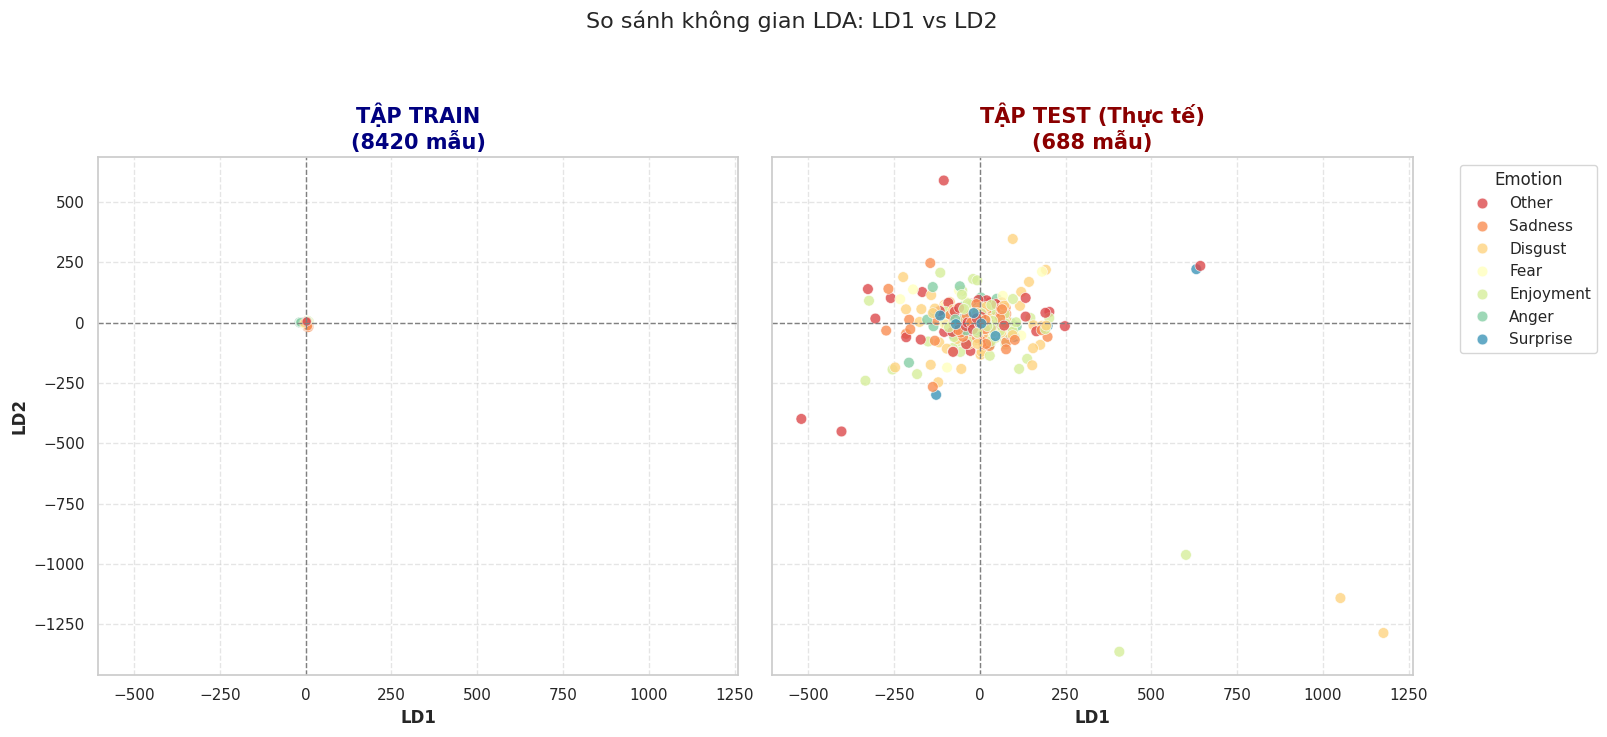

In [90]:
X_test_lda_merged = lda_merged.transform(X_test_arr_merged)

test_lda_merged_df = pd.DataFrame(X_test_lda_merged, columns=[f'LD{k+1}' for k in range(X_test_lda_merged.shape[1])])
test_lda_merged_df['Emotion'] = y_test_merged.values

compare_lda_train_test(X_train_valid_lda_merged_df, test_lda_merged_df, pair=(0,1))

#### Vẽ cách 2 (nhưng mà cách này chạy lâu)

In [ ]:
# pairs_lda = [(0,1), (0,2), (1,2), (2,3), (3,4), (4,5)]

# for i, j in pairs_lda:
#     lda1 = train_lda_df[f'LD{i+1}']
#     lda2 = train_lda_df[f'LD{j+1}']
#     plot_scatter(lda1, lda2, X_train_pca_df['Emotion'],
#                  title=f"LDA Scatter Plot: LD{i+1} vs LD{j+1}")

#### Mối quan hệ của 6 TPC đầu tiên với các nhãn

/tmp/ipython-input-1335423673.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=X_train_valid_lda_merged_df, x='Emotion', y=f'LD{i+1}', palette='Spectral')


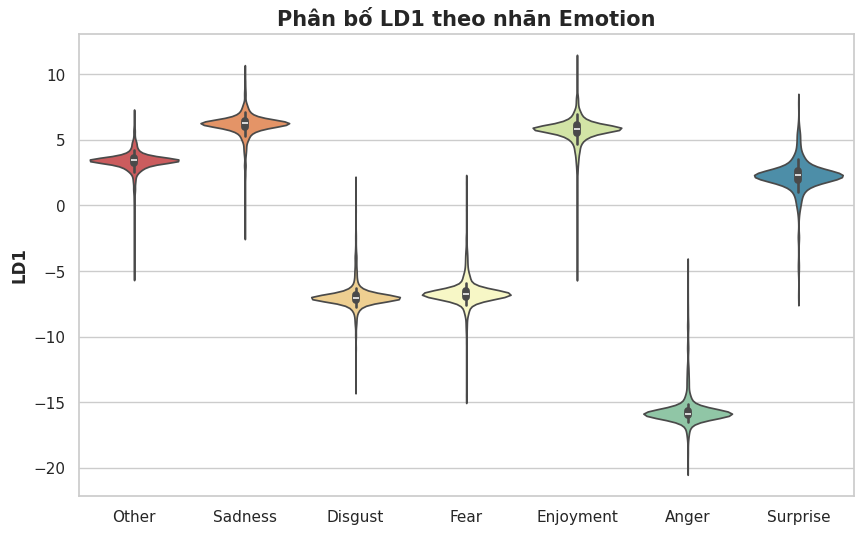

/tmp/ipython-input-1335423673.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=X_train_valid_lda_merged_df, x='Emotion', y=f'LD{i+1}', palette='Spectral')


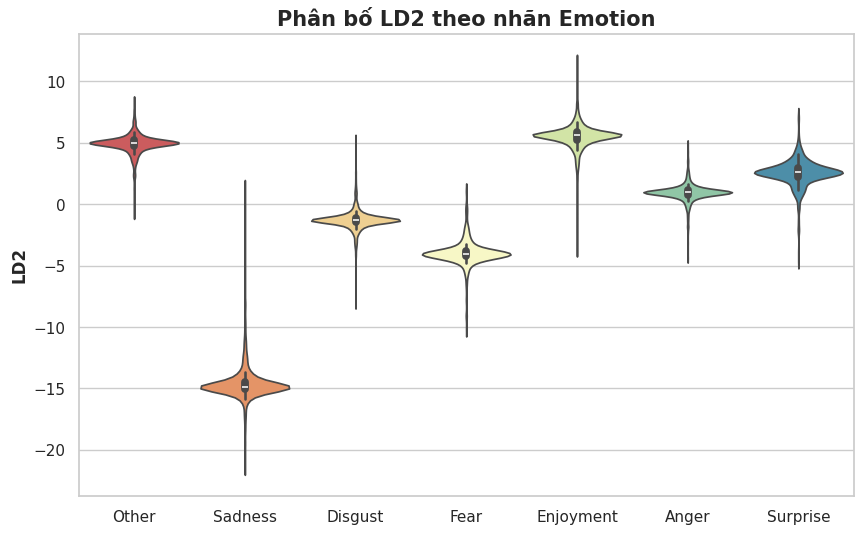

/tmp/ipython-input-1335423673.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=X_train_valid_lda_merged_df, x='Emotion', y=f'LD{i+1}', palette='Spectral')


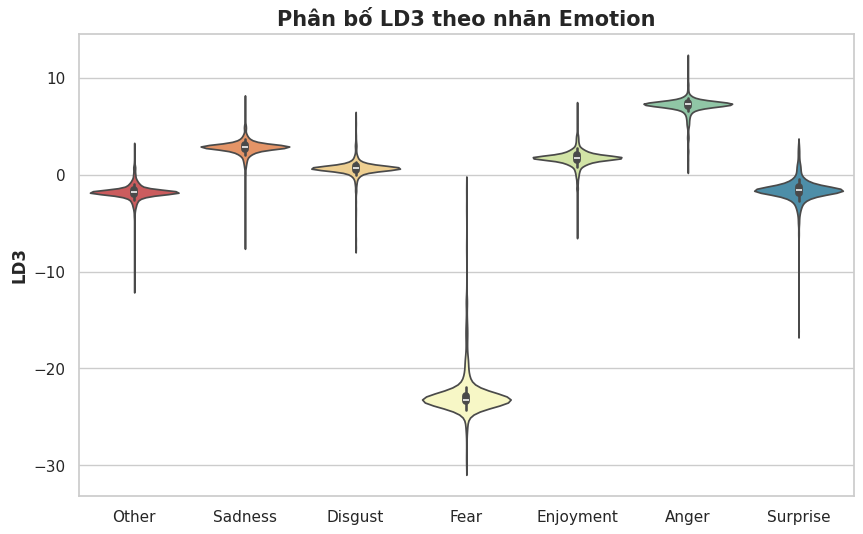

/tmp/ipython-input-1335423673.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=X_train_valid_lda_merged_df, x='Emotion', y=f'LD{i+1}', palette='Spectral')


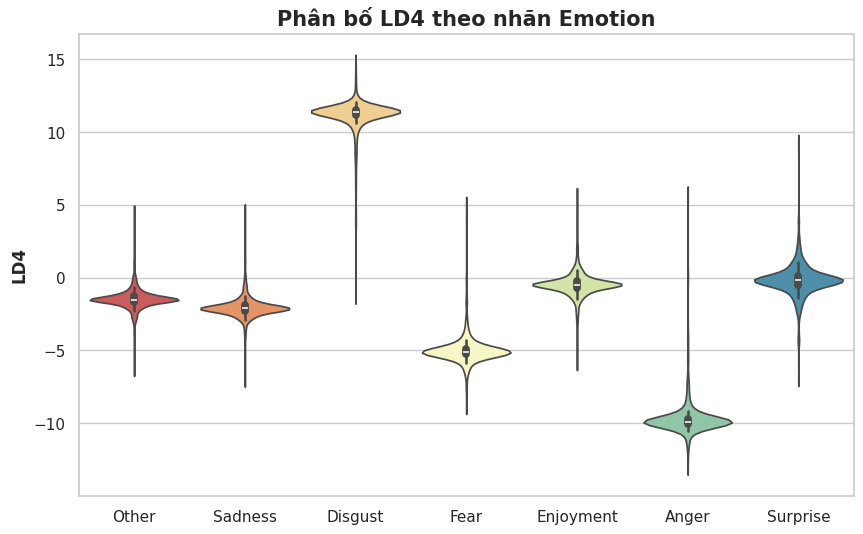

/tmp/ipython-input-1335423673.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=X_train_valid_lda_merged_df, x='Emotion', y=f'LD{i+1}', palette='Spectral')


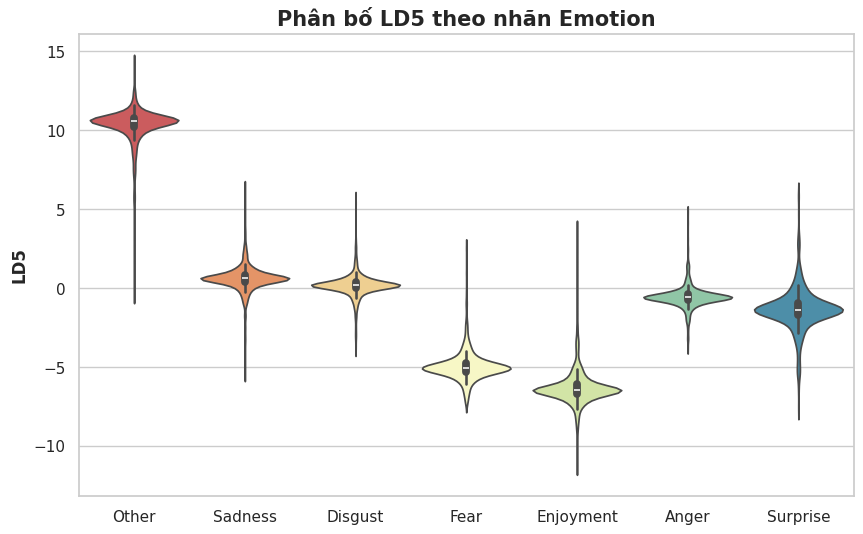

/tmp/ipython-input-1335423673.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=X_train_valid_lda_merged_df, x='Emotion', y=f'LD{i+1}', palette='Spectral')


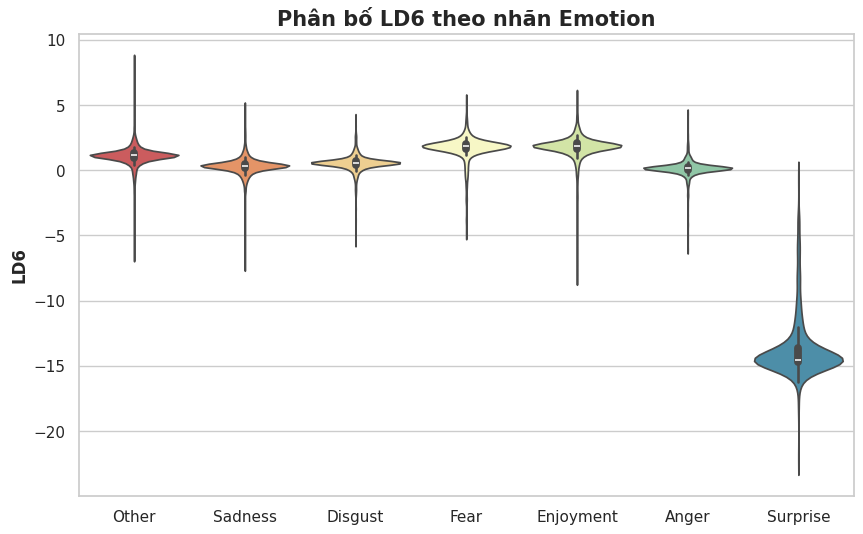

In [91]:
for i in range(6):
    plt.figure(figsize=(10,6))
    sns.violinplot(data=X_train_valid_lda_merged_df, x='Emotion', y=f'LD{i+1}', palette='Spectral')
    plt.title(f'Phân bố {f"LD{i+1}"} theo nhãn Emotion')
    plt.xlabel('')
    plt.ylabel(f'LD{i+1}')
    plt.show()

## test_density

In [100]:
def plot_lda_density(X_lda, y, title_pre='', component_index=0):
    """
    Vẽ biểu đồ mật độ phân phối (Density Plot) cho một thành phần LDA cụ thể.

    Args:
        X_lda: Dữ liệu sau khi giảm chiều (Output của LDA transform)
        y: Nhãn (Emotion)
        component_index: Thứ tự trục muốn vẽ (0 là LD1, 1 là LD2...)
    """

    # 1. Tạo DataFrame tạm để vẽ
    # Lấy tên cột là LD1, LD2... tùy theo index truyền vào
    col_name = f'LD{component_index + 1}'
    df_plot = pd.DataFrame({
        col_name: X_lda[:, component_index],
        'Emotion': y
    })

    # 2. Thiết lập Style giống hình mẫu
    sns.set_style("whitegrid") # Nền trắng có lưới
    plt.figure(figsize=(12, 6))

    # 3. Vẽ KDE Plot (Phần quan trọng nhất)
    sns.kdeplot(
        data=df_plot,
        x=col_name,
        hue='Emotion',      # Phân màu theo cảm xúc
        fill=True,          # Tô màu bên dưới đường cong (giống hình mẫu)
        alpha=0.3,          # Độ trong suốt (để nhìn thấy phần chồng lên nhau)
        linewidth=1.5,      # Độ dày đường viền
        palette='tab10',    # Bảng màu chuẩn
        common_norm=False   # QUAN TRỌNG: Chuẩn hóa riêng từng class để class ít mẫu cũng hiện rõ đỉnh
    )

    # 4. Trang trí
    plt.title(f'LDA - Phân phối các lớp trên trục {col_name} {title_pre}', fontsize=16, fontweight='bold')
    plt.xlabel(f'Giá trị {col_name}', fontsize=12)
    plt.ylabel('Mật độ (Density)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)

    # Di chuyển chú thích ra ngoài nếu quá rối
    plt.legend(title='Emotion', labels=df_plot['Emotion'].unique(),
               bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

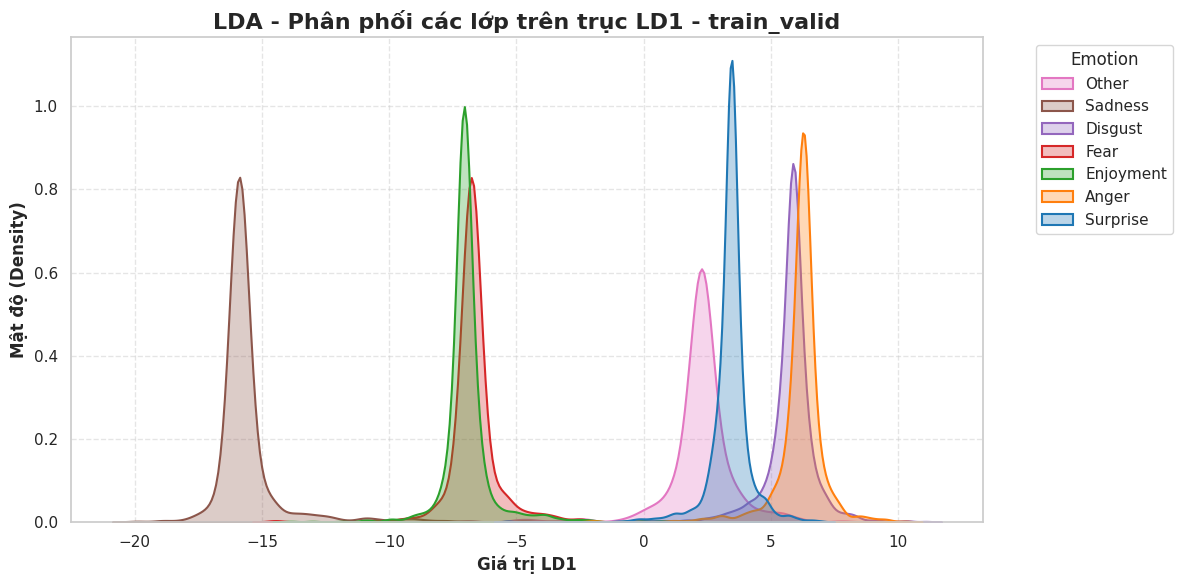

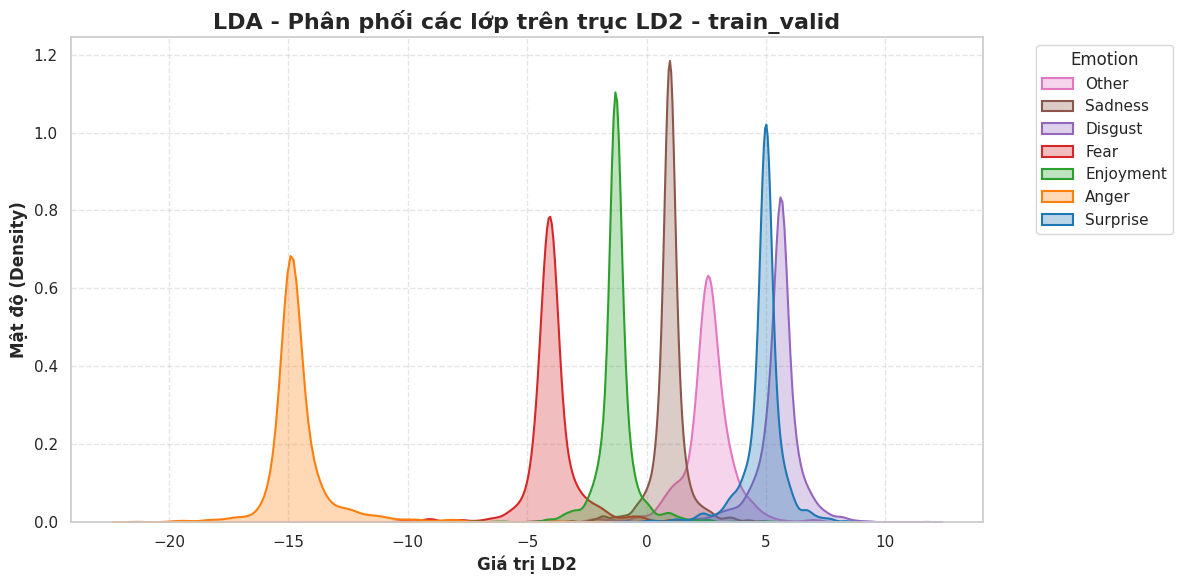

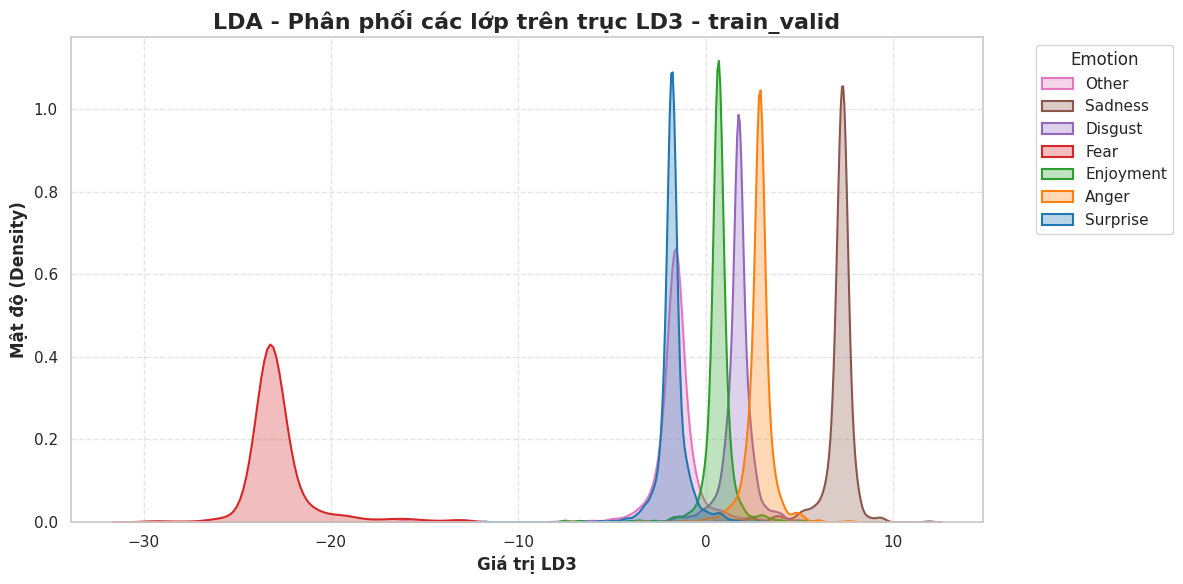

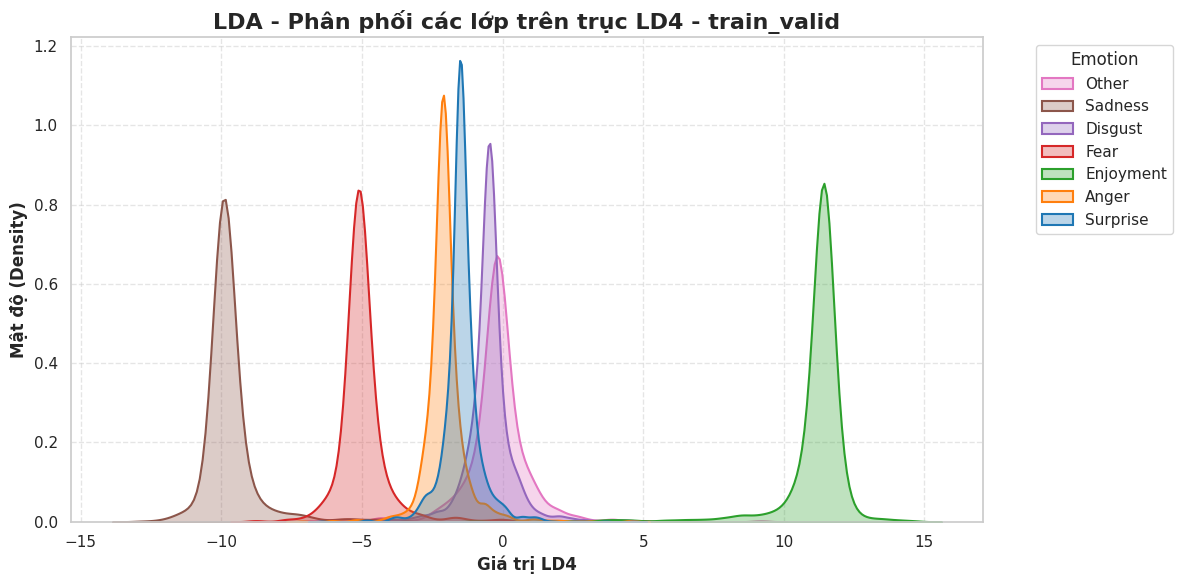

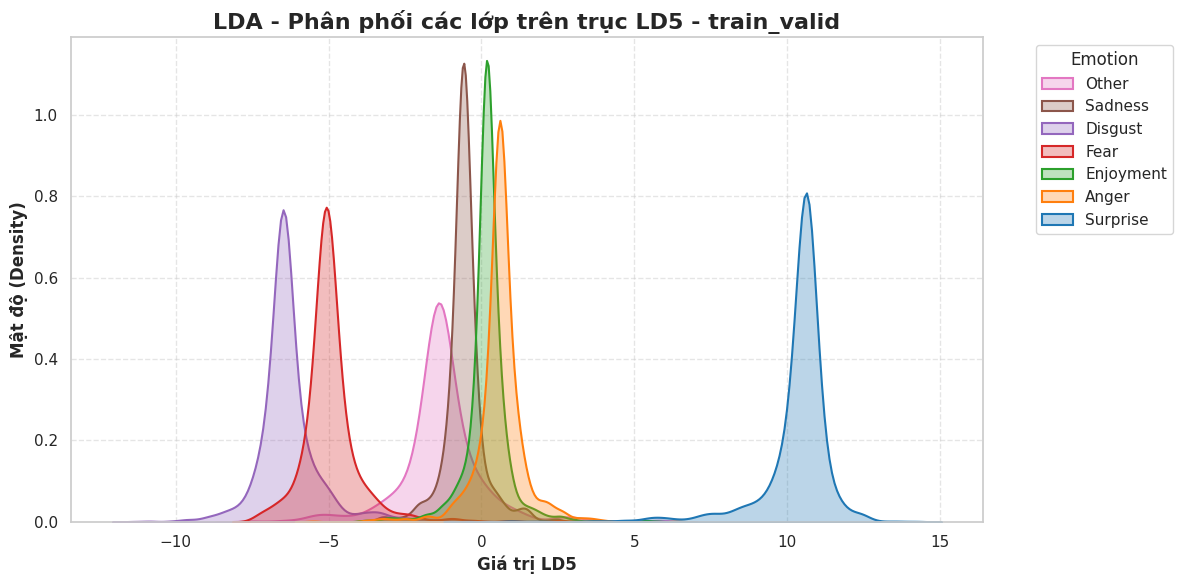

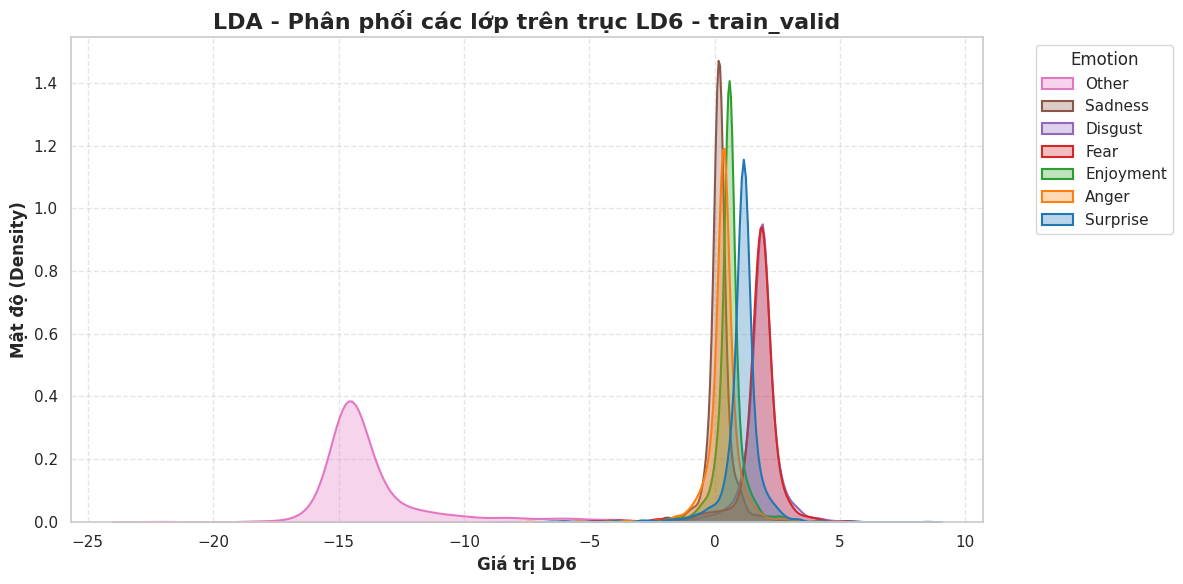

In [101]:
for i in range(6):
    plot_lda_density(X_train_valid_lda_merged, y_train_valid_merged, title_pre="- train_valid", component_index=i)

# plot_lda_density(X_train_valid_lda_merged, y_train_valid_merged, component_index=0)

# Nếu muốn xem trục LD2 thì đổi index=1
# plot_lda_density(X_train_valid_lda_merged, y_train_valid_merged, component_index=1)

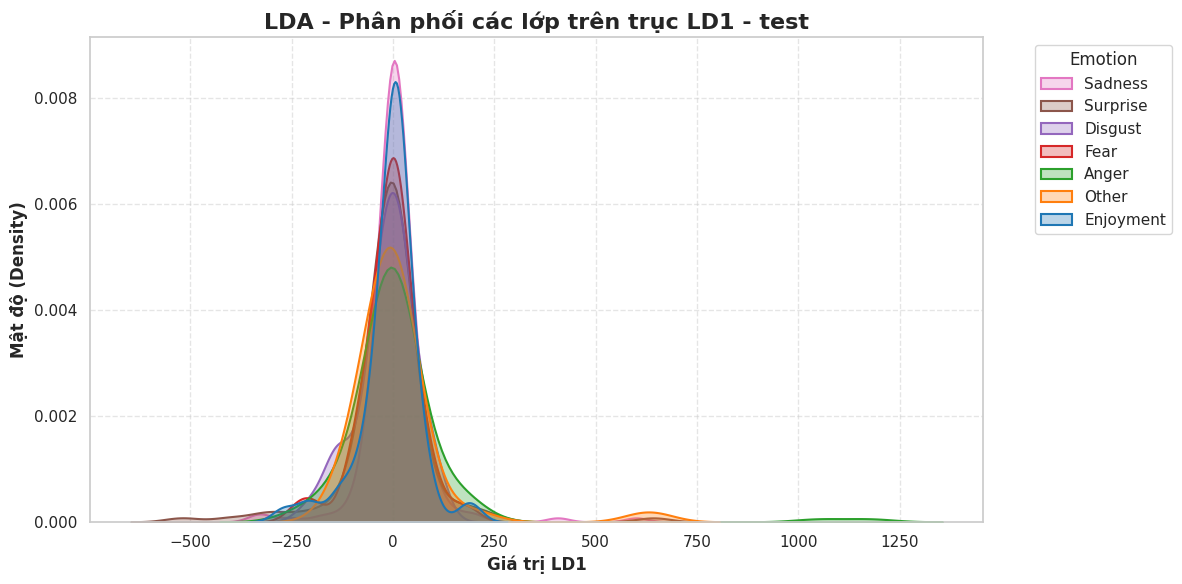

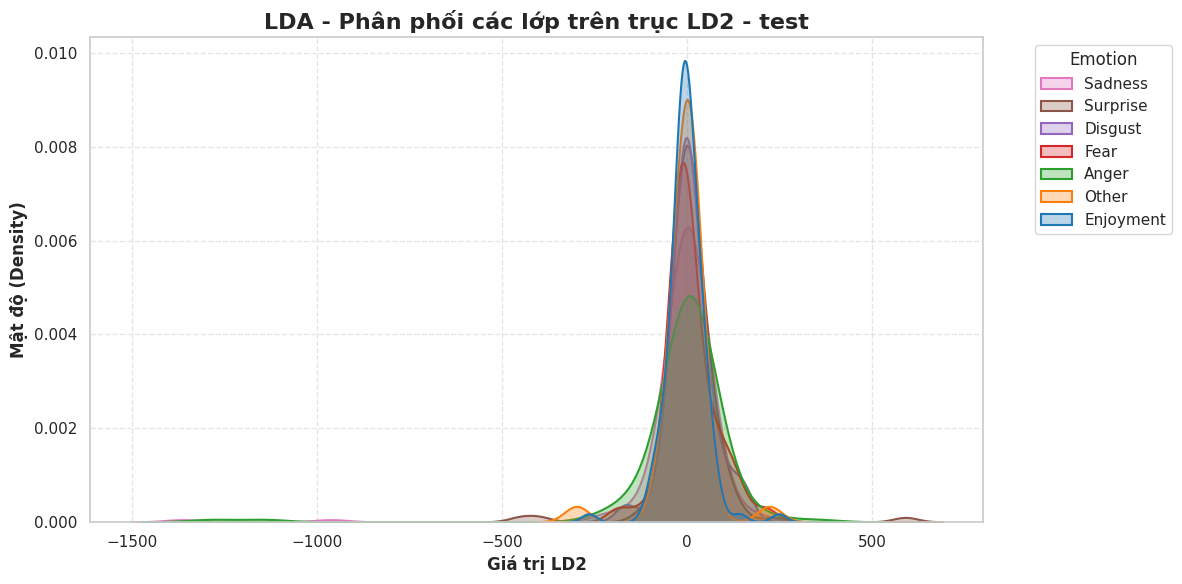

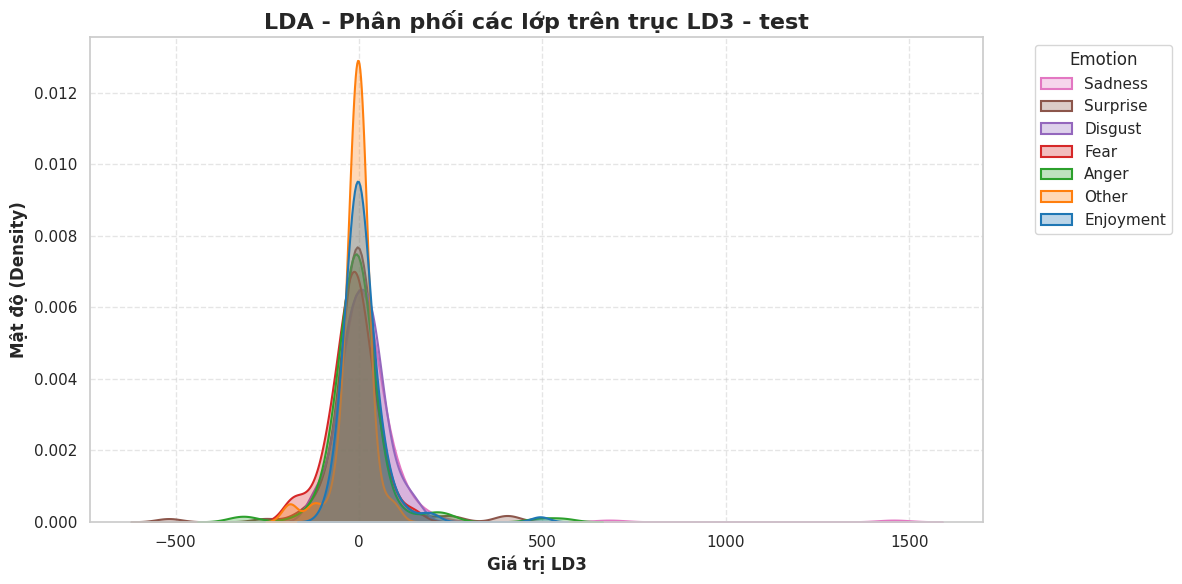

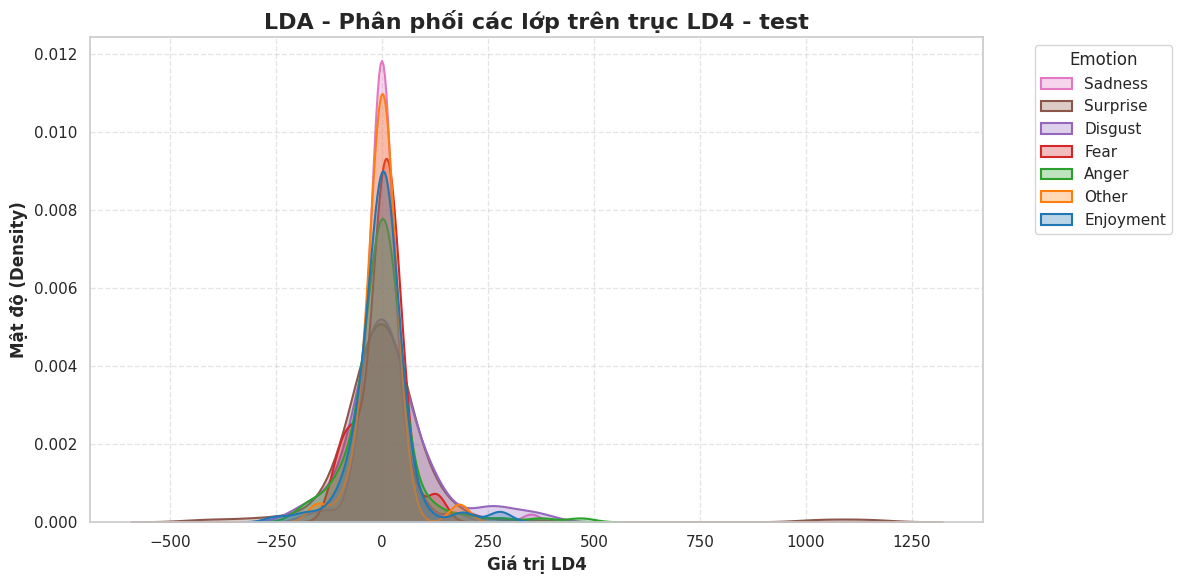

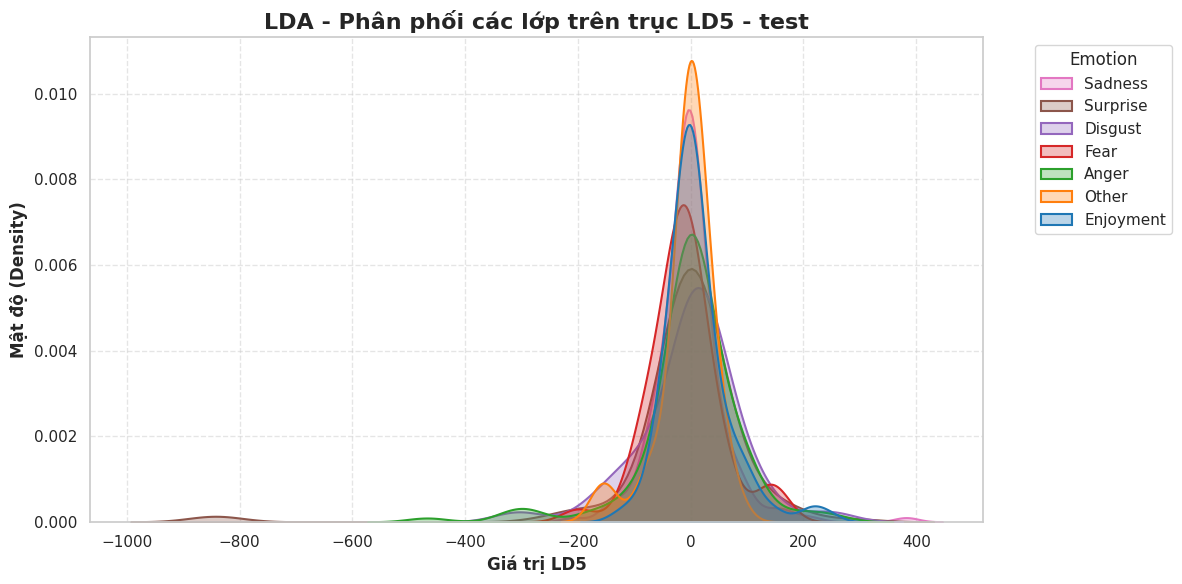

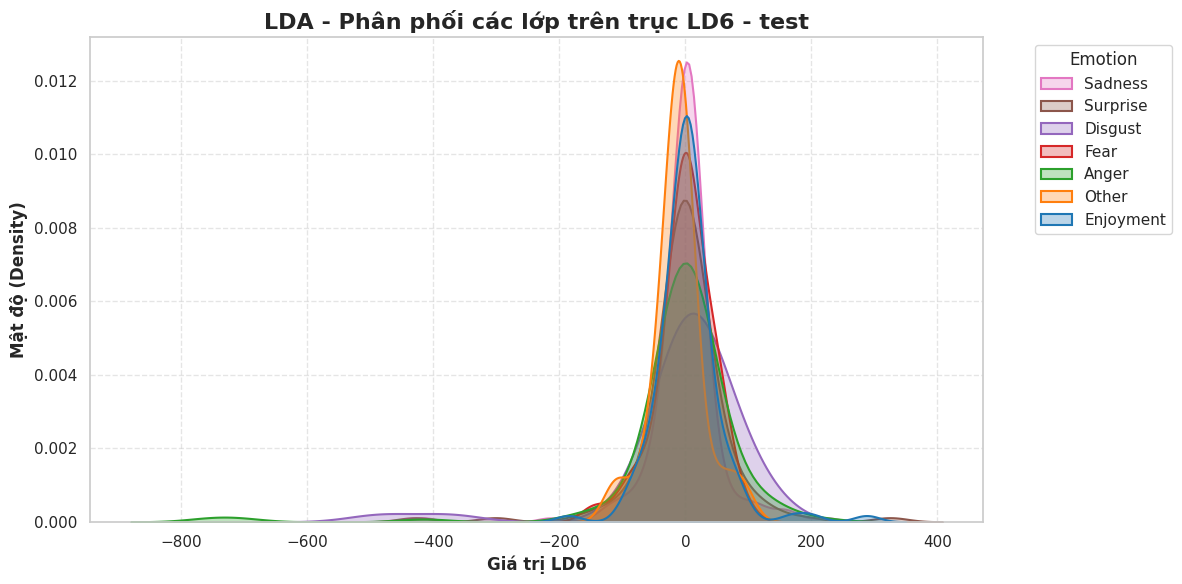

In [102]:
for i in range(6):
    plot_lda_density(X_test_lda_merged, y_test_merged, title_pre="- test", component_index=i)

In [103]:
def plot_pca_density(X_pca, y, component_index=0):
    """
    Vẽ biểu đồ mật độ phân phối (Density Plot) cho một thành phần PCA cụ thể.

    Args:
        X_pca: Dữ liệu sau khi giảm chiều bằng PCA/SVD (Output của transform)
        y: Nhãn (Emotion)
        component_index: Thứ tự trục muốn vẽ (0 là PC1, 1 là PC2...)
    """

    # 1. Tạo tên cột (PC1, PC2...)
    col_name = f'PC{component_index + 1}'

    # 2. Tạo DataFrame tạm
    df_plot = pd.DataFrame({
        col_name: X_pca[:, component_index],
        'Emotion': y
    })

    # 3. Thiết lập Style
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 6))

    # 4. Vẽ KDE Plot
    sns.kdeplot(
        data=df_plot,
        x=col_name,
        hue='Emotion',
        fill=True,
        alpha=0.3,
        linewidth=1.5,
        palette='tab10',
        common_norm=False  # Giữ nguyên False để so sánh hình dáng phân phối dễ hơn
    )

    # 5. Trang trí
    plt.title(f'PCA - Phân phối các lớp trên trục {col_name}', fontsize=16, fontweight='bold')
    plt.xlabel(f'Giá trị {col_name} (Phương sai lớn thứ {component_index + 1})', fontsize=12)
    plt.ylabel('Mật độ (Density)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)

    # Legend
    plt.legend(title='Emotion', labels=df_plot['Emotion'].unique(),
               bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

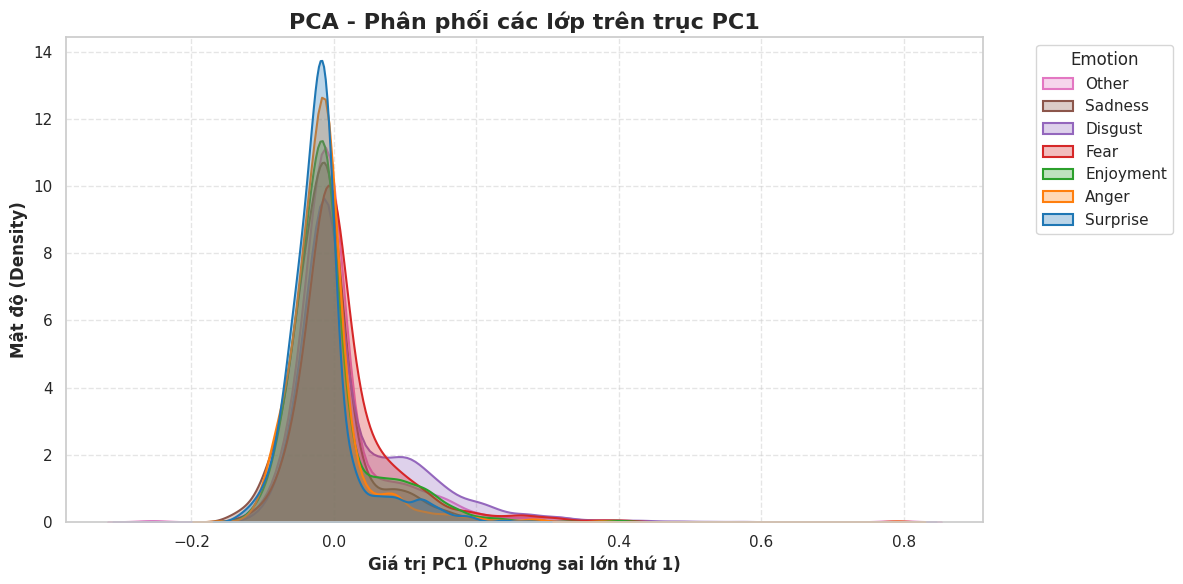

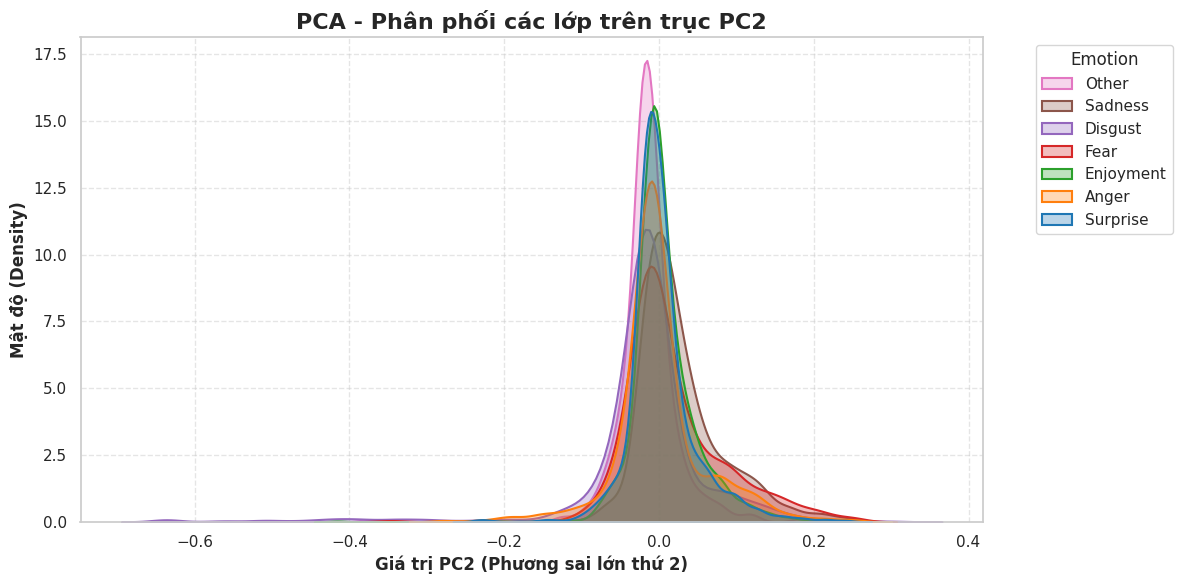

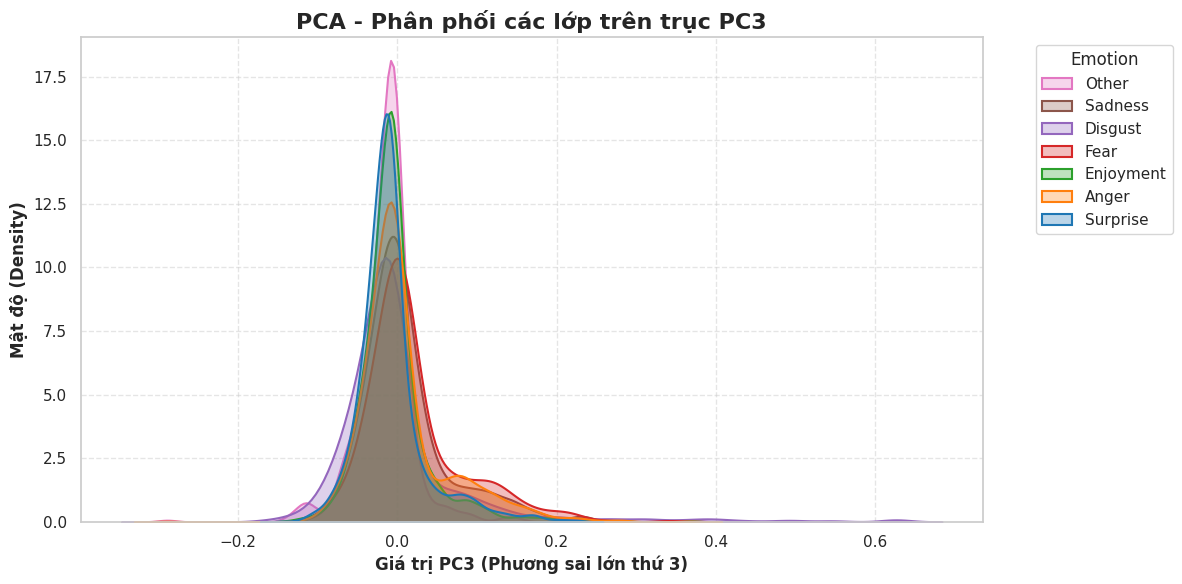

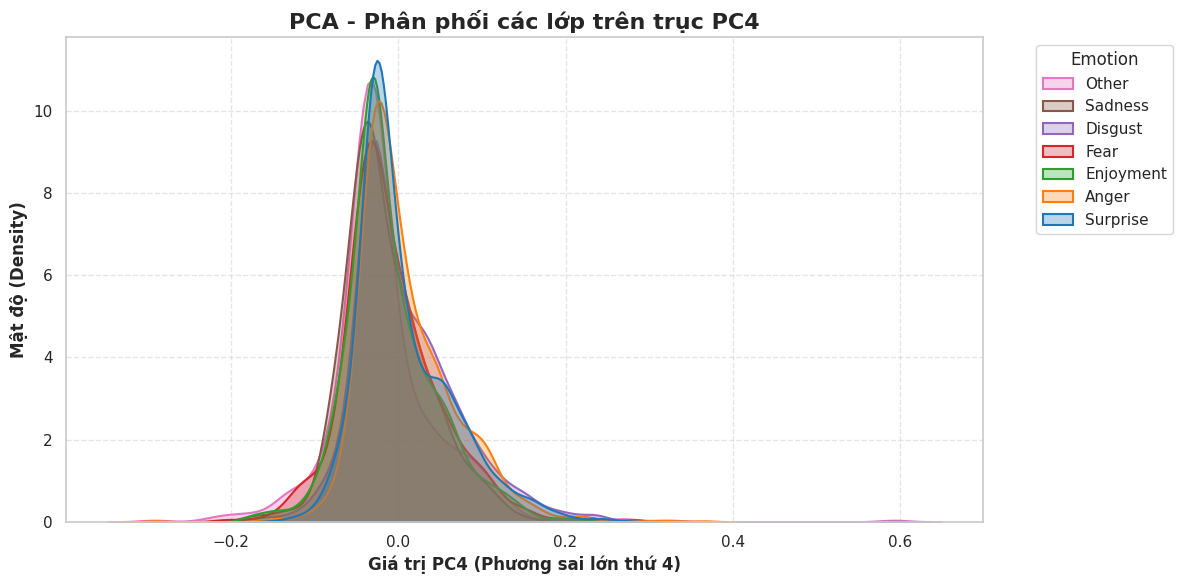

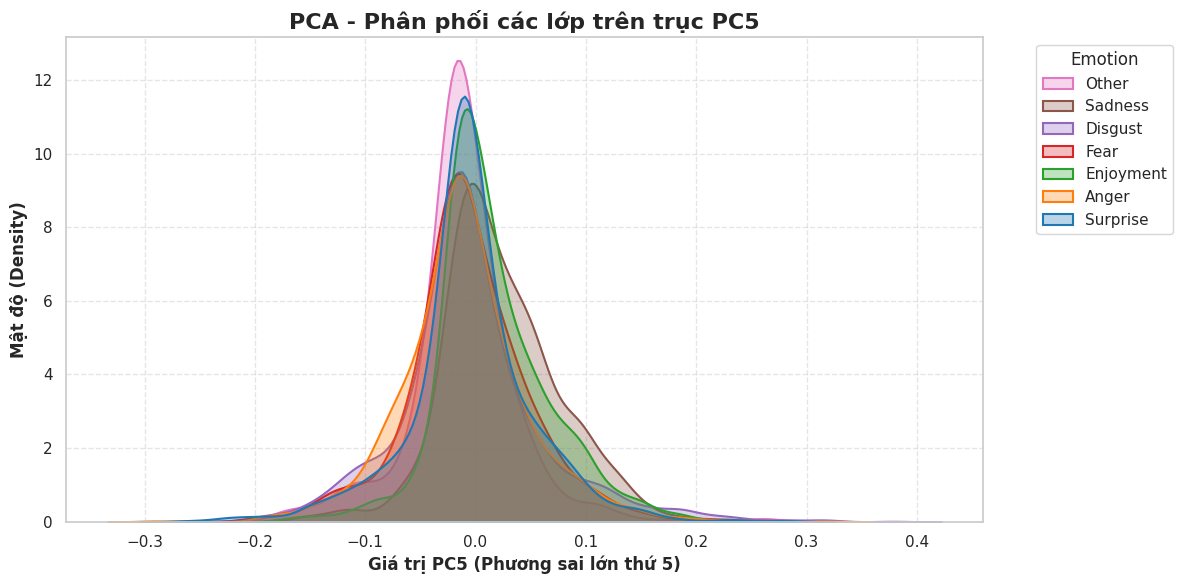

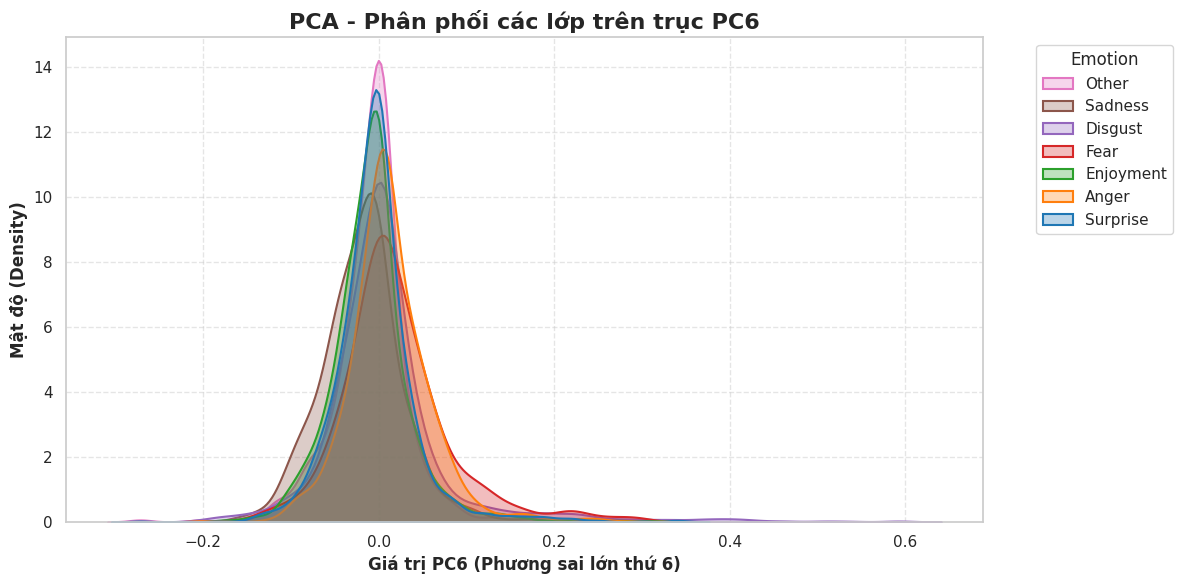

In [104]:
for i in range(6):
    plot_pca_density(X_train_valid_pca_merged, y_train_valid_merged, component_index=i)